# Debugging, static int_tumor_type, custom loss, history, epochs

In [1]:
(1)
# Data Processing and Visualization
import os
import random
import glob
import re
import pickle
from tifffile import TiffFile,TiffFileError

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import math
import seaborn as sns
import albumentations as A  # Import Albumentations
import imgaug.augmenters as iaa  # For mild data augmentation
from imgaug.augmentables.segmaps import SegmentationMapsOnImage


# Image Processing and Visualization
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform
from PIL import Image
# Deep Learning Framework (TensorFlow/Keras)
import tensorflow as tf

# Specific TensorFlow/Keras Components
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, BatchNormalization, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    EarlyStopping, 
    ModelCheckpoint,
    CSVLogger,
    Callback, 
    LearningRateScheduler
)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
import tensorflow.keras.backend as K

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from IPython.display import display
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.losses import binary_crossentropy

Datamap imports the path of images and store them to a variable

In [2]:
(2)
datamap = []
error_files = []

# Specify the path to your dataset on your Windows machine
dataset_path = "Seg_MRI"

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob(dataset_path + "/*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        # Extract the tumor type from the directory name
        dir_name = os.path.basename(sub_dir_path)

        # Iterate over files in the directory
        for filename in os.listdir(sub_dir_path):
            # Construct the full path to the image file
            image_path = os.path.join(sub_dir_path, filename)
            
            # Attempt to load the image
            try:
                # Check if the file is a TIFF file
                if image_path.lower().endswith('.tiff') or image_path.lower().endswith('.tif'):
                    try:
                        with TiffFile(image_path) as tif:
                            # Add the TIFF file to the datamap
                            datamap.append({
                                'tumor_type': dir_name,
                                'file_name': filename,
                                'file_path': image_path,
                                'image': tif.asarray()
                            })
                    except TiffFileError as e:
                        # Add the full file path and error message to the list of error files
                        error_files.append((image_path, str(e)))
                else:
                    # Load non-TIFF image formats using OpenCV
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    
                    # Check if the image is successfully loaded
                    if image is not None:
                        # Append a dictionary to the datamap
                        datamap.append({
                            'tumor_type': dir_name,
                            'file_name': filename,
                            'file_path': image_path,  # Include the full file path
                            'image': image
                        })
                    else:
                        # Add the full file path to the list of error files
                        error_files.append(image_path)
            except Exception as e:
                # Add the full file path and error message to the list of error files
                error_files.append((image_path, str(e)))

# Display the datamap
for entry in datamap[:10]:  # Display only the first 10 entries
    print(f"Tumor Type: {entry['tumor_type']}, File Name: {entry['file_name']}, File Path: {entry['file_path']}, Image Shape: {entry['image'].shape}")

# Display the list of error files
print("\nError Files:")
for error in error_files:
    if isinstance(error, tuple):
        print(f"Error loading file '{error[0]}': {error[1]}")
    else:
        print(f"Error loading file '{error}'")


Tumor Type: Astrocytoma, File Name: Astrocytoma_T1CE_000.tif, File Path: Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000.tif, Image Shape: (630, 630, 3)
Tumor Type: Astrocytoma, File Name: Astrocytoma_T1CE_000_mask.tif, File Path: Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000_mask.tif, Image Shape: (630, 630)
Tumor Type: Astrocytoma, File Name: Astrocytoma_T1CE_001.tif, File Path: Seg_MRI\Astrocytoma\Astrocytoma_T1CE_001.tif, Image Shape: (630, 630, 3)
Tumor Type: Astrocytoma, File Name: Astrocytoma_T1CE_001_mask.tif, File Path: Seg_MRI\Astrocytoma\Astrocytoma_T1CE_001_mask.tif, Image Shape: (630, 630)
Tumor Type: Astrocytoma, File Name: Astrocytoma_T1CE_002.tif, File Path: Seg_MRI\Astrocytoma\Astrocytoma_T1CE_002.tif, Image Shape: (630, 630, 3)
Tumor Type: Astrocytoma, File Name: Astrocytoma_T1CE_002_mask.tif, File Path: Seg_MRI\Astrocytoma\Astrocytoma_T1CE_002_mask.tif, Image Shape: (630, 630)
Tumor Type: Astrocytoma, File Name: Astrocytoma_T1CE_003.tif, File Path: Seg_MRI\Astrocytoma\Astrocytom

Coverting the datamap to dataframe

In [3]:
(3)
# Convert the data_map to a pandas DataFrame
datamap_df = pd.DataFrame(datamap)
print(datamap_df.head())
print(datamap_df.tail())
# print(datamap_df)

    tumor_type                      file_name  \
0  Astrocytoma       Astrocytoma_T1CE_000.tif   
1  Astrocytoma  Astrocytoma_T1CE_000_mask.tif   
2  Astrocytoma       Astrocytoma_T1CE_001.tif   
3  Astrocytoma  Astrocytoma_T1CE_001_mask.tif   
4  Astrocytoma       Astrocytoma_T1CE_002.tif   

                                           file_path  \
0       Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000.tif   
1  Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000_mask.tif   
2       Seg_MRI\Astrocytoma\Astrocytoma_T1CE_001.tif   
3  Seg_MRI\Astrocytoma\Astrocytoma_T1CE_001_mask.tif   
4       Seg_MRI\Astrocytoma\Astrocytoma_T1CE_002.tif   

                                               image  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
       tumor_type    file_name        

In [4]:
(4)
# Filtering image paths and mask paths
df_imgs = datamap_df[~datamap_df['file_path'].str.contains("mask")]
df_masks = datamap_df[datamap_df['file_path'].str.contains("mask")]

# Creating a dictionary for mask paths with tumor type
mask_dict = {path[:-9]: (path, tumor_type) for path, tumor_type in zip(df_masks["file_path"].values, df_masks["tumor_type"].values)}

# Pairing each image with its corresponding mask and tumor type
pairs = []
for image_path, tumor_type in zip(df_imgs["file_path"].values, df_imgs["tumor_type"].values):
    base_path = image_path[:-4]  # Remove the '.tif' extension
    mask_info = mask_dict.get(base_path)  # Retrieve the corresponding mask path and tumor type
    if mask_info:
        mask_path, mask_tumor_type = mask_info
        # Ensure the tumor type matches for both image and mask
        if tumor_type == mask_tumor_type:
            pairs.append({'Tumor_Type': tumor_type, 'Image_Path': image_path, 'Mask_Path': mask_path})

# Convert pairs list to DataFrame
pairs_df = pd.DataFrame(pairs)

# Sort the DataFrame by 'Tumor Type'
final_df = pairs_df.sort_values(by='Tumor_Type').reset_index(drop=True)

# Display the updated DataFrame
print(final_df.head())  # Shows the first few rows


    Tumor_Type                                    Image_Path  \
0  Astrocytoma  Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000.tif   
1  Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_052.tif   
2  Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_053.tif   
3  Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_054.tif   
4  Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_055.tif   

                                           Mask_Path  
0  Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000_mask.tif  
1    Seg_MRI\Astrocytoma\Astrocytoma_T1_052_mask.tif  
2    Seg_MRI\Astrocytoma\Astrocytoma_T1_053_mask.tif  
3    Seg_MRI\Astrocytoma\Astrocytoma_T1_054_mask.tif  
4    Seg_MRI\Astrocytoma\Astrocytoma_T1_055_mask.tif  


In [5]:
final_df

Tumor_Type                                    Image_Path  \
0    Astrocytoma  Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000.tif   
1    Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_052.tif   
2    Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_053.tif   
3    Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_054.tif   
4    Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_055.tif   
..           ...                                           ...   
825  Neurocytoma                   Seg_MRI\Neurocytoma\144.tif   
826  Neurocytoma                   Seg_MRI\Neurocytoma\142.tif   
827  Neurocytoma                   Seg_MRI\Neurocytoma\140.tif   
828  Neurocytoma                    Seg_MRI\Neurocytoma\17.tif   
829  Neurocytoma                    Seg_MRI\Neurocytoma\98.tif   

                                             Mask_Path  
0    Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000_mask.tif  
1      Seg_MRI\Astrocytoma\Astrocytoma_T1_052_mask.tif  
2      Seg_MRI\Astrocytoma\Astrocytoma_T1_053_mask.tif  
3      Seg_MRI\Astrocytoma\Astrocytoma_T1_054_mask.tif  
4      Seg_MRI\Astrocytoma\Astrocytoma_T1_055_mask.tif  
..                                                 ...  
825                   Seg_MRI\Neurocytoma\144_mask.tif  
826                   Seg_MRI\Neurocytoma\142_mask.tif  
827                   Seg_MRI\Neurocytoma\140_mask.tif  
828                    Seg_MRI\Neurocytoma\17_mask.tif  
829                    Seg_MRI\Neurocytoma\98_mask.tif  

[830 rows x 3 columns]

Displaying the images with mask

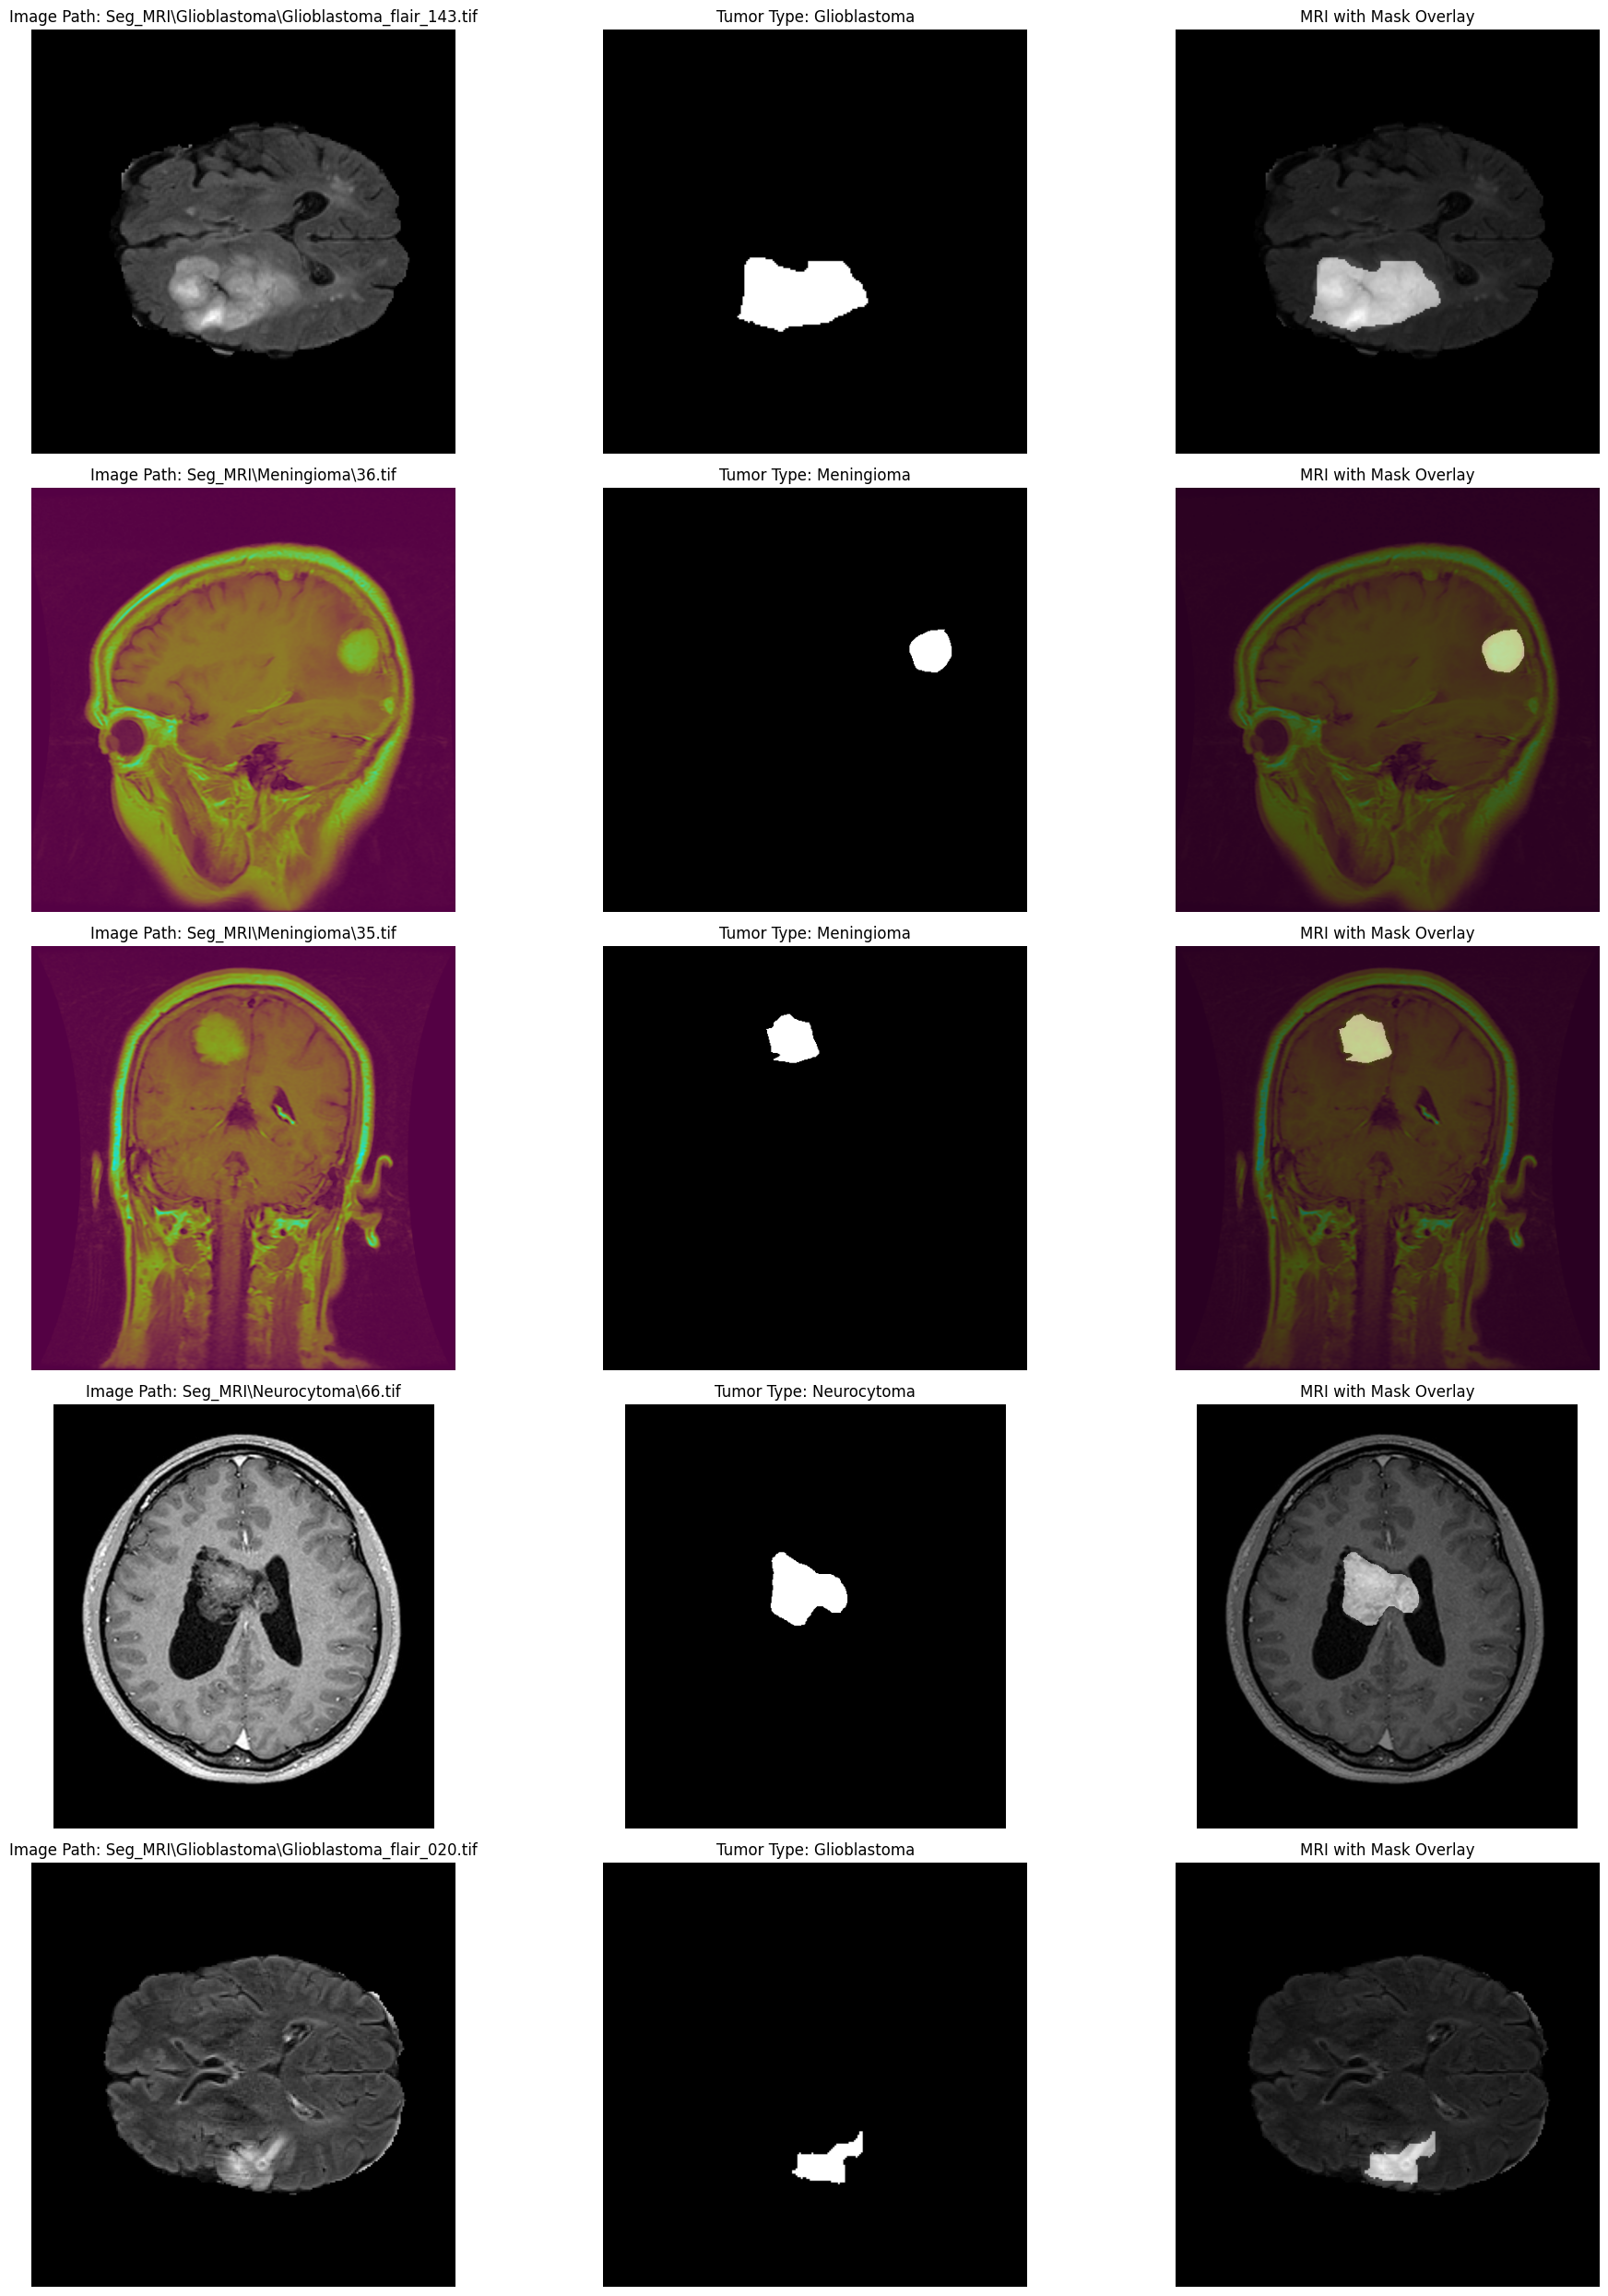

In [6]:
(5)
# Randomly select a pair
idx = random.randint(0, len(final_df) - 1)
selected_row = final_df.iloc[idx]

# Paths
img_path = selected_row['Image_Path']
mask_path = selected_row['Mask_Path']
tumor_type = selected_row['Tumor_Type']

# Load the image and mask
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

# Debugging Start
# plt.figure(figsize=(8, 6))
# plt.imshow(mask, cmap='gray')
# plt.title('Mask')
# plt.axis('off')
# plt.show()
# print(np.unique(mask))
# Debugging end

num_samples = min(len(final_df), 5)  # Display up to 5 samples
random_indices = random.sample(range(len(final_df)), num_samples)

fig, axs = plt.subplots(num_samples, 3, figsize=(20, num_samples * 5))  

for count, idx in enumerate(random_indices):
    row = final_df.iloc[idx]

    img_path = row['Image_Path']
    mask_path = row['Mask_Path']
    tumor_type = row['Tumor_Type']

    # Load images without any color conversion
    image = cv2.imread(img_path) 
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 

    # Display
    axs[count][0].imshow(image)  
    axs[count][0].set_title(f"Image Path: {img_path}")
    axs[count][0].axis('off')

    axs[count][1].imshow(mask, cmap='gray') 
    axs[count][1].set_title(f"Tumor Type: {tumor_type}")
    axs[count][1].axis('off')

    # Overlay the mask on the original image
    img_with_overlay = cv2.addWeighted(image, 0.5, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB), 0.5, 0)
    axs[count][2].imshow(img_with_overlay)
    axs[count][2].set_title("MRI with Mask Overlay")
    axs[count][2].axis('off')

fig.tight_layout()
plt.show()





Labeling Tumor Types

In [7]:
(6)
# Check if a saved LabelEncoder exists
try:
    with open('Model_Weights/label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
        print("Loaded existing LabelEncoder")  

except FileNotFoundError:  
    # No saved encoder found. Create a new one.
    label_encoder = LabelEncoder()
    final_df['Tumor_Type_Int'] = label_encoder.fit_transform(final_df['Tumor_Type']) 

    # Save the LabelEncoder for future use
    with open('Model_Weights/label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
        print("Saved new LabelEncoder")

# Recreate 'Tumor_Type_Int' if missing 
if 'Tumor_Type_Int' not in final_df.columns:
    final_df['Tumor_Type_Int'] = label_encoder.transform(final_df['Tumor_Type']) 

# Now, 'Tumor Type Int' column should exist
print(final_df[['Tumor_Type', 'Tumor_Type_Int']].head())

Loaded existing LabelEncoder
    Tumor_Type  Tumor_Type_Int
0  Astrocytoma               0
1  Astrocytoma               0
2  Astrocytoma               0
3  Astrocytoma               0
4  Astrocytoma               0


checking if the inverse is working or not 

In [8]:
(7)
# inverse mapping from integer labels back to original string labels
try:
    with open('Model_Weights/inverse_mapping.pkl', 'rb') as f:
        inverse_mapping = pickle.load(f)
        print("Loaded existing inverse_mapping") 

except FileNotFoundError: 
    inverse_mapping = {i: label for i, label in enumerate(label_encoder.classes_)} 

    with open('Model_Weights/inverse_mapping.pkl', 'wb') as f:
        pickle.dump(inverse_mapping, f) 
        print("Saved new inverse_mapping") 
print(label_encoder)

Loaded existing inverse_mapping
LabelEncoder()


In [9]:
print(inverse_mapping) 

{0: 'Astrocytoma', 1: 'Glioblastoma', 2: 'Gliomas', 3: 'Meningioma', 4: 'Neurocytoma'}


In [10]:
final_df

Tumor_Type                                    Image_Path  \
0    Astrocytoma  Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000.tif   
1    Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_052.tif   
2    Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_053.tif   
3    Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_054.tif   
4    Astrocytoma    Seg_MRI\Astrocytoma\Astrocytoma_T1_055.tif   
..           ...                                           ...   
825  Neurocytoma                   Seg_MRI\Neurocytoma\144.tif   
826  Neurocytoma                   Seg_MRI\Neurocytoma\142.tif   
827  Neurocytoma                   Seg_MRI\Neurocytoma\140.tif   
828  Neurocytoma                    Seg_MRI\Neurocytoma\17.tif   
829  Neurocytoma                    Seg_MRI\Neurocytoma\98.tif   

                                             Mask_Path  Tumor_Type_Int  
0    Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000_mask.tif               0  
1      Seg_MRI\Astrocytoma\Astrocytoma_T1_052_mask.tif               0  
2      Seg_MRI\Astrocytoma\Astrocytoma_T1_053_mask.tif               0  
3      Seg_MRI\Astrocytoma\Astrocytoma_T1_054_mask.tif               0  
4      Seg_MRI\Astrocytoma\Astrocytoma_T1_055_mask.tif               0  
..                                                 ...             ...  
825                   Seg_MRI\Neurocytoma\144_mask.tif               4  
826                   Seg_MRI\Neurocytoma\142_mask.tif               4  
827                   Seg_MRI\Neurocytoma\140_mask.tif               4  
828                    Seg_MRI\Neurocytoma\17_mask.tif               4  
829                    Seg_MRI\Neurocytoma\98_mask.tif               4  

[830 rows x 4 columns]

# Split data into training, testing, validation

In [11]:
(8)
# Split the main dataset into training and a temporary test set with 15% of the data
X_train, X_temp_test = train_test_split(final_df, test_size=0.15, random_state=42)

# Split the temporary test set into validation and test sets equally
X_val, X_test = train_test_split(X_temp_test, test_size=0.5, random_state=42)

# Display the sizes of each dataset
print(f"Train size is {len(X_train)}, validation size is {len(X_val)}, & test size is {len(X_test)}")

# Extract 'Image_Path' and 'Mask_Path' for training, validation, and test datasets
train_ids = list(X_train['Image_Path'])
train_masks = list(X_train['Mask_Path'])

val_ids = list(X_val['Image_Path'])
val_masks = list(X_val['Mask_Path'])

test_ids = list(X_test['Image_Path'])
test_masks = list(X_test['Mask_Path'])


Train size is 705, validation size is 62, & test size is 63


Preprocessing

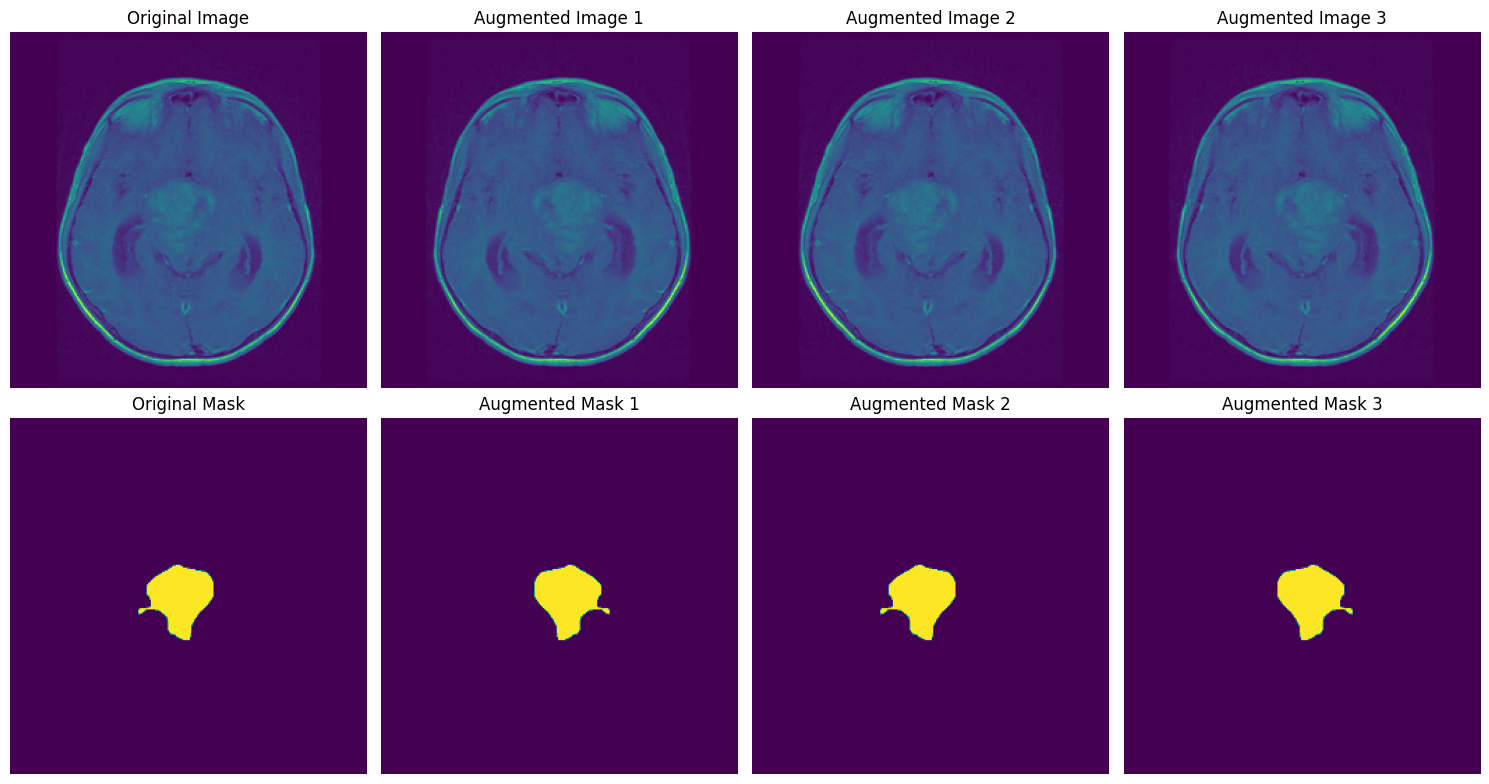

In [12]:
(9)
def preprocess_image(image_path, mask_path, target_size=(256, 256), augment=False):
    # Load image and mask
    image = cv2.imread(image_path)  
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 
    except Exception as e:
        print(f"Error loading mask: {e}")

    # Debug Point 1: Check original shapes
    # print("Image shape (original):", image.shape)
    # print("Mask shape (original):", mask.shape)
    
    # Grayscale Conversion
    if len(image.shape) == 3:  # Check if already grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Ensure channel dimension for grayscale
    image = np.expand_dims(image, axis=-1)  
  
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 

    # Resize
    image = cv2.resize(image, target_size)
    mask = cv2.resize(mask, target_size) 

    # Data augmentation with Albumentations
    if augment:
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),   # Replace with your desired augmentations
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.3)
        ])
        transformed = transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']

    # Type casting and normalization
    image = image.astype(np.float32) / 255.0
    mask = mask.astype(np.float32) / 255.0  

    # Debug Point 2: Check shapes after preprocessing
    # print("Image shape (preprocessed):", image.shape)
    # print("Mask shape (preprocessed):", mask.shape)

    return image, mask

# Displaying the images with preproccesing
def display_preprocessed_sample(image_path, mask_path, target_size=(256, 256), num_augs=3):
    # Random image selection
    idx = random.randint(0, len(final_df) - 1)  # Assuming 'final_df' holds your data
    image_path = final_df.iloc[idx]['Image_Path']
    mask_path = final_df.iloc[idx]['Mask_Path']

    # Load and preprocess without augmentation (for reference)
    image, mask = preprocess_image(image_path, mask_path, target_size, augment=False)

    fig, axs = plt.subplots(nrows=2, ncols=num_augs + 1, figsize=(15, 8))

    # Original image and mask
    axs[0, 0].imshow(image)
    axs[0, 0].set_title("Original Image")
    axs[1, 0].imshow(mask)
    axs[1, 0].set_title("Original Mask")

    # Augmented versions
    for i in range(1, num_augs + 1):
        image_aug, mask_aug = preprocess_image(image_path, mask_path, target_size, augment=True)
        axs[0, i].imshow(image_aug)
        axs[0, i].set_title(f"Augmented Image {i}")
        axs[1, i].imshow(mask_aug)
        axs[1, i].set_title(f"Augmented Mask {i}")

    for ax in axs.flat:  # Remove extra axes ticks 
        ax.axis('off')

    plt.tight_layout()
    plt.show()

display_preprocessed_sample(image_path, mask_path) 

# Data Generator

In [13]:
(10)

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, labels, batch_size, image_size, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indexes[start_idx:end_idx]

        # Data loading and preprocessing
        labels = np.empty((len(batch_indices),), dtype=int)

        images = [] 
        masks = []

        for i, idx in enumerate(batch_indices):
            image_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]
            
            # Apply preprocessing with optional augmentation
            image, mask = preprocess_image(image_path, mask_path, self.image_size, augment=True) 

            labels[i] = self.labels[idx]
            # Debug Point 3: Check shapes inside __getitem__
            # print("Image shape (in __getitem__):", image.shape)
            # print("Mask shape (in __getitem__):", mask.shape)

            # Don't squeeze if you want to keep the channels dimension 
            images.append(image)  
            masks.append(mask)  

        images = np.stack(images, axis=0) 
        masks = np.stack(masks, axis=0)   

        return images, {'segmentation_output': masks, 'classification_output': labels} 
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Assuming you have your DataFrames (X_train, X_val) and label columns:
train_generator = CustomDataGenerator(
    image_paths=X_train['Image_Path'].tolist(),
    mask_paths=X_train['Mask_Path'].tolist(),
    labels=X_train['Tumor_Type_Int'].tolist(),
    batch_size=16,
    image_size=(256, 256),
    shuffle=True
)

val_generator = CustomDataGenerator(
    image_paths=X_val['Image_Path'].tolist(),
    mask_paths=X_val['Mask_Path'].tolist(),
    labels=X_val['Tumor_Type_Int'].tolist(),
    batch_size=16,
    image_size=(256, 256),
    shuffle=False
) 


Debugging

In [14]:
batch_index = 0  # or any valid index within the range of available batches
# Fetch batch data
X_batch, outputs_batch = train_generator.__getitem__(batch_index)

# Extract masks and labels from the outputs dictionary
masks_batch = outputs_batch['segmentation_output']
labels_batch = outputs_batch['classification_output']

print("Labels:", labels_batch)



Labels: [3 1 4 1 0 3 2 0 1 1 1 1 0 1 1 1]


Visuals of Preprocessing

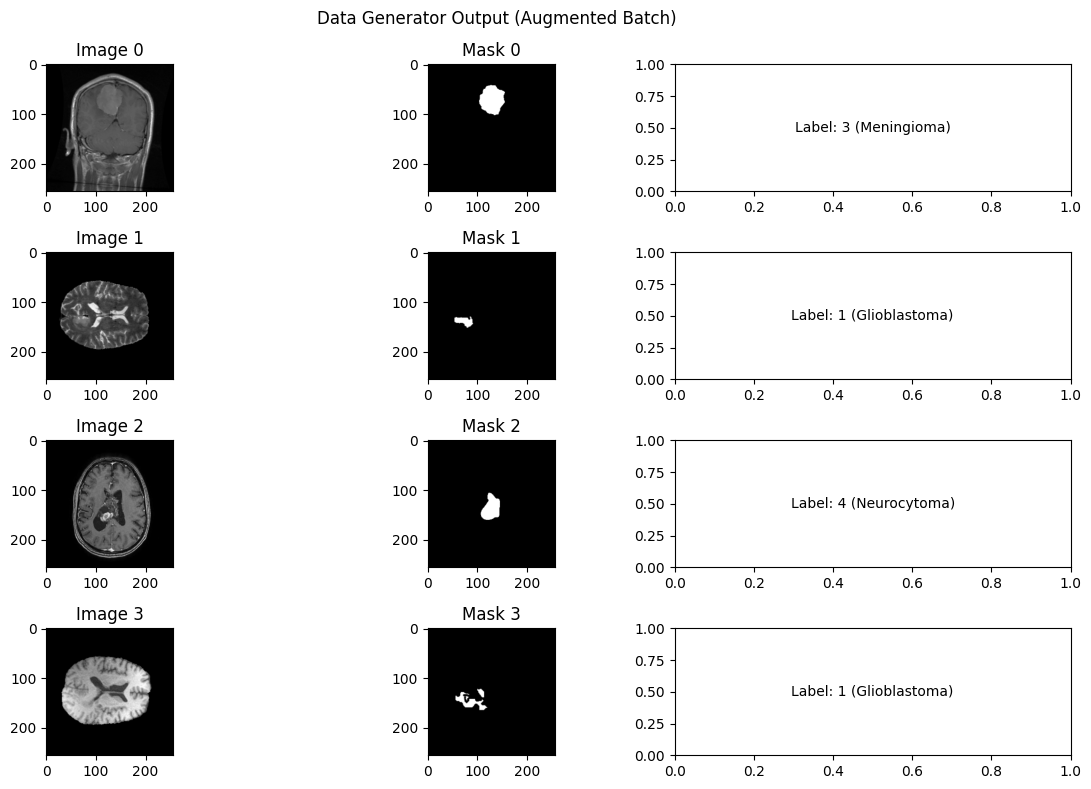

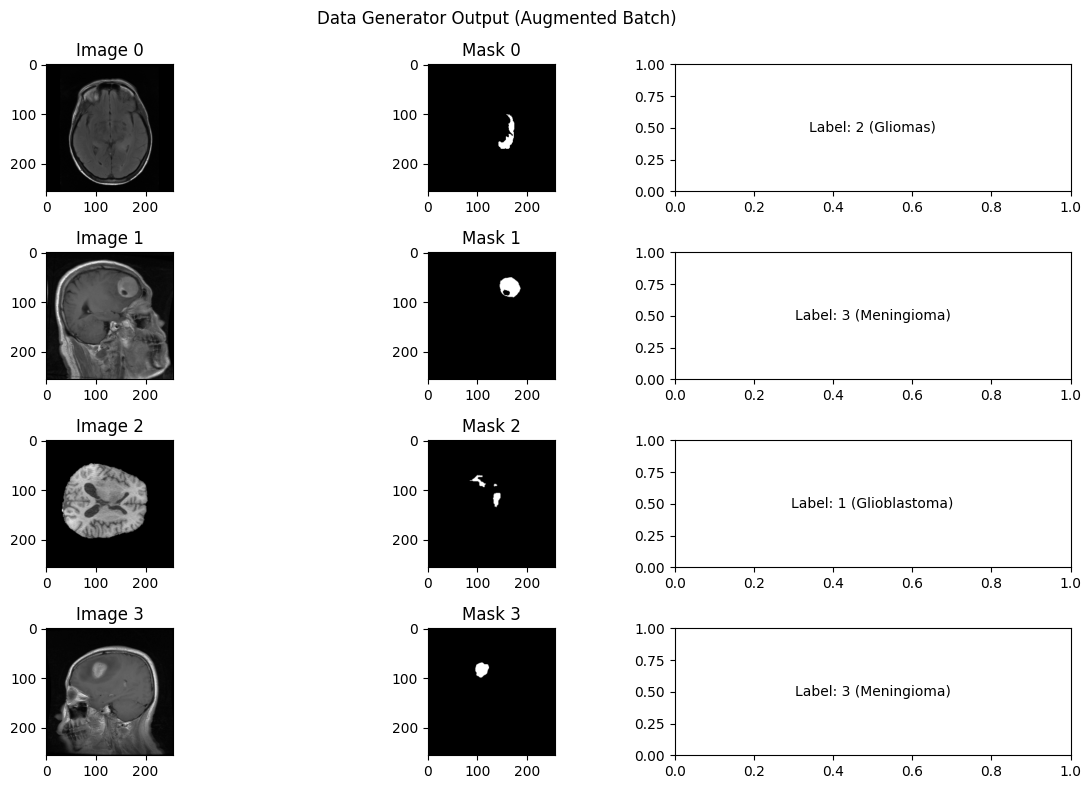

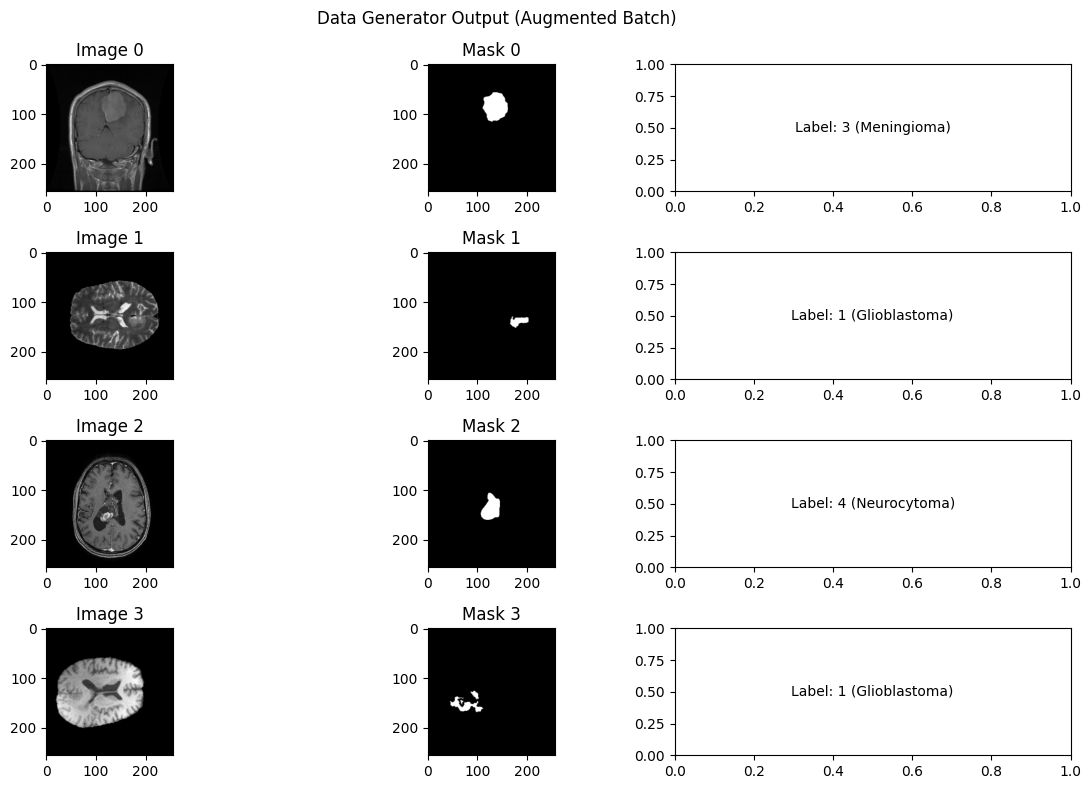

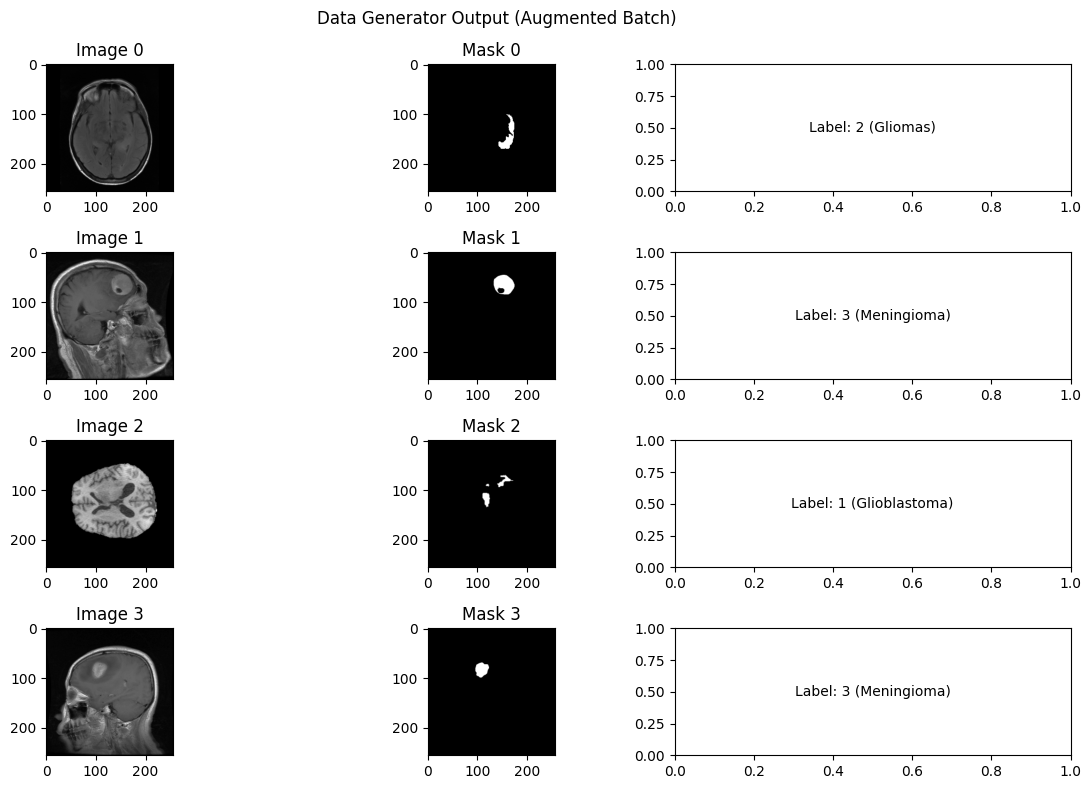

In [15]:
(11)
if __name__ == "__main__": 
    # Visualization loop
    batch_size = 4  
    num_batches_to_display = 2
    for i in range(num_batches_to_display):  
        images, outputs = train_generator.__getitem__(i)  

        for i in range(num_batches_to_display):
            images, outputs = train_generator.__getitem__(i)  
            # Debug Point 4: Check shape before visualization
            # print("Image shape (before imshow):", images[0].shape) 

            fig, axs = plt.subplots(nrows=batch_size, ncols=3, figsize=(12, 8))
            fig.suptitle('Data Generator Output (Augmented Batch)')

            for j in range(batch_size):
                image = images[j]
                mask = outputs['segmentation_output'][j]
                label = outputs['classification_output'][j]

                axs[j, 0].imshow(image, cmap='gray')
                axs[j, 0].set_title(f"Image {j}")
                axs[j, 1].imshow(mask, cmap='gray')
                axs[j, 1].set_title(f"Mask {j}")

                label = outputs['classification_output'][j]  # Get the integer label

                # Access the textual label using your inverse mapping
                label_text = inverse_mapping[label] 
                # Display both the integer and text labels
                axs[j, 2].text(0.5, 0.5, f"Label: {label} ({label_text})", 
                            horizontalalignment='center',
                            verticalalignment='center', 
                            transform=axs[j, 2].transAxes)

            plt.tight_layout()
            plt.show()


Just Display with overlay

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


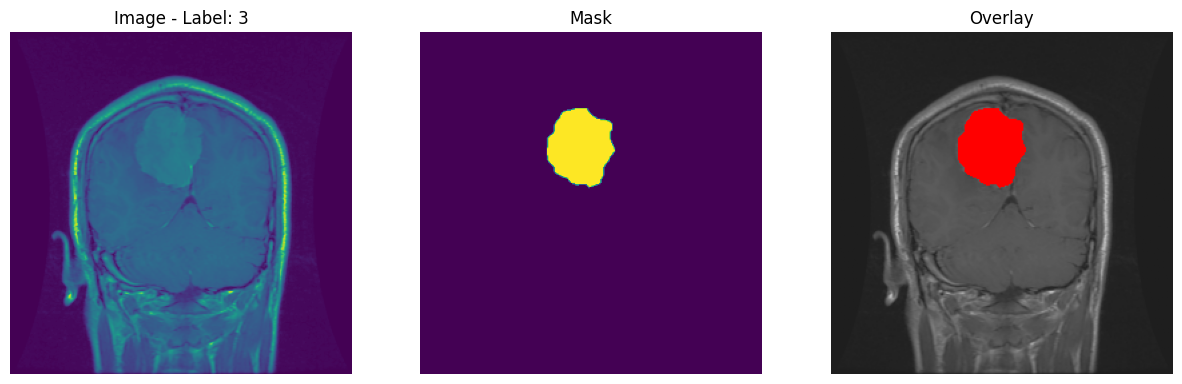

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


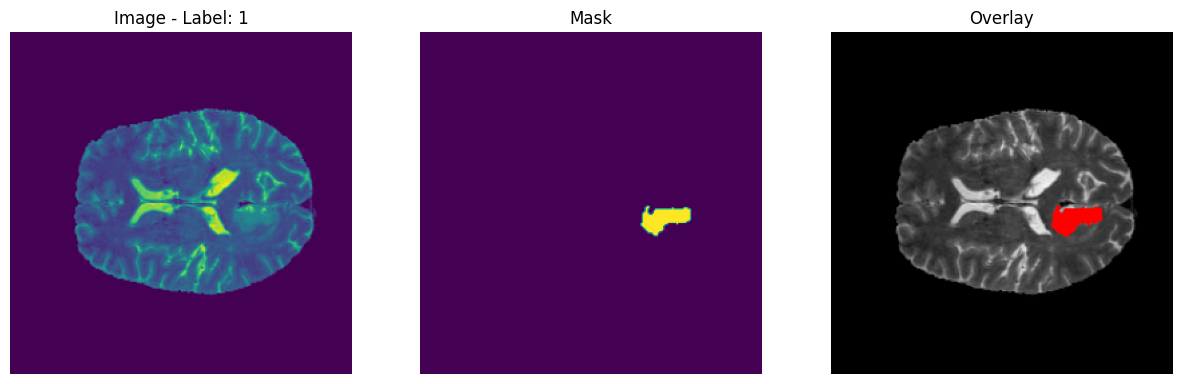

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


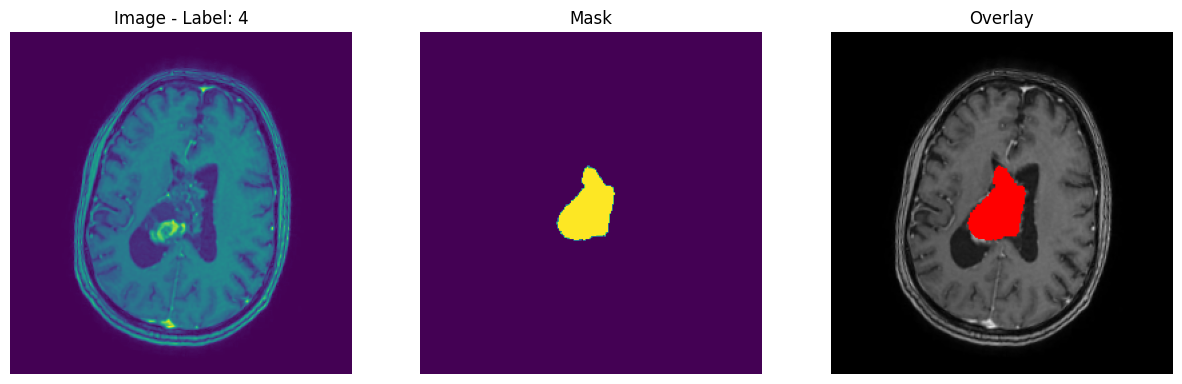

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


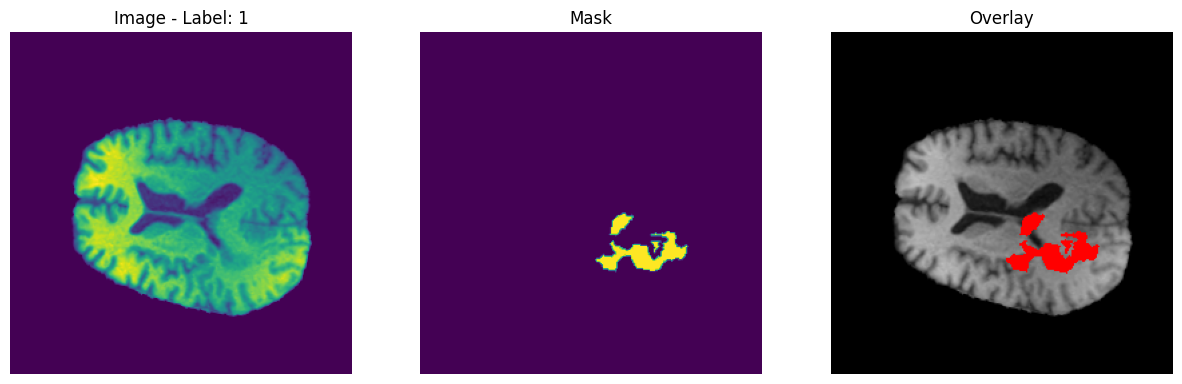

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


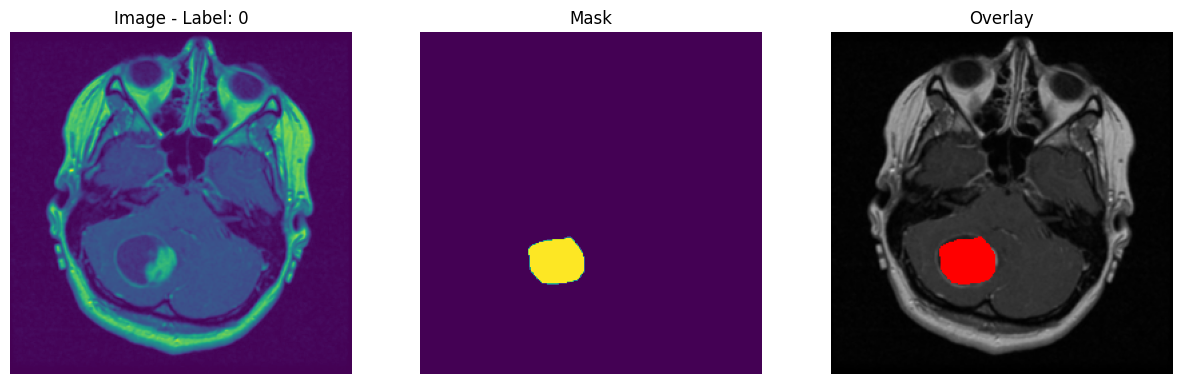

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


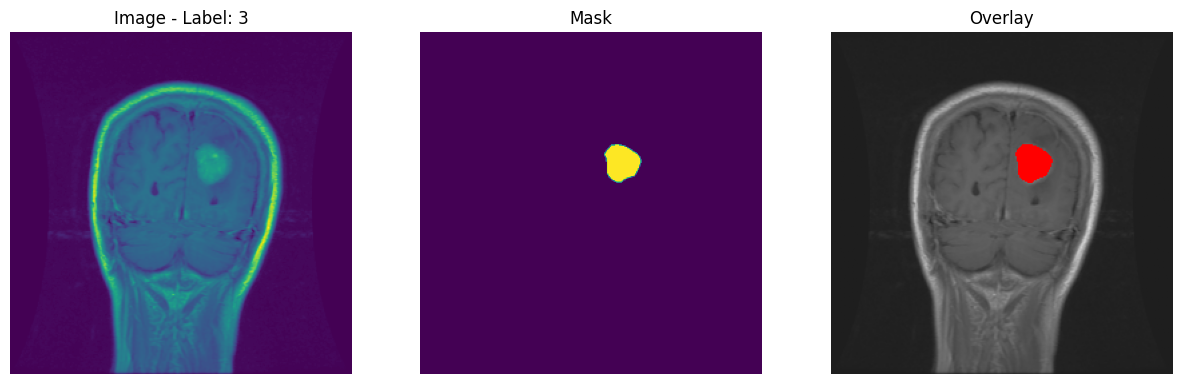

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


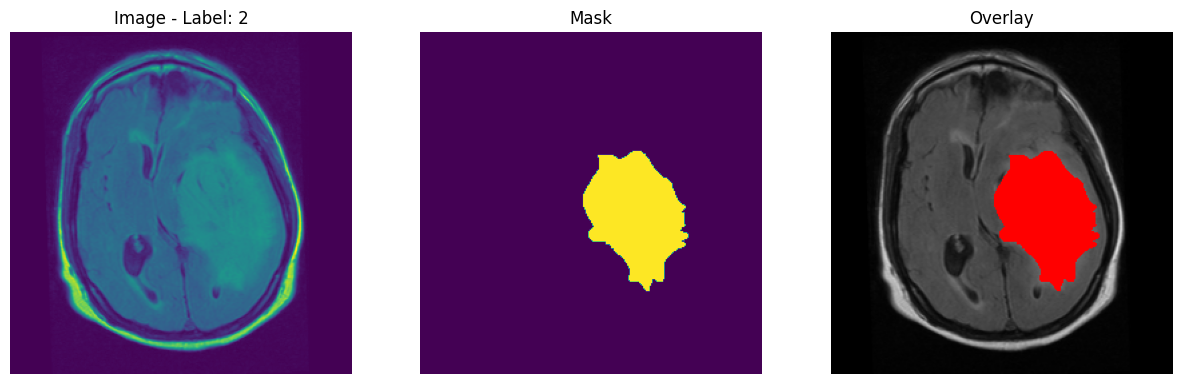

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


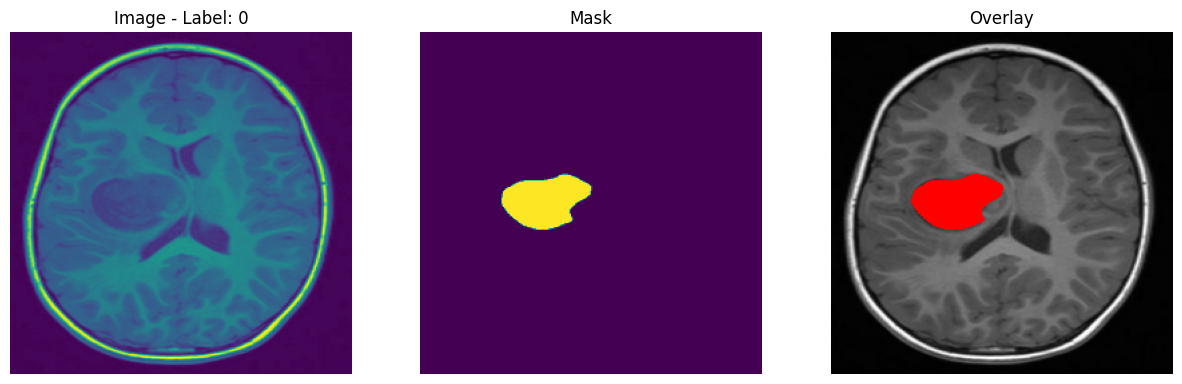

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


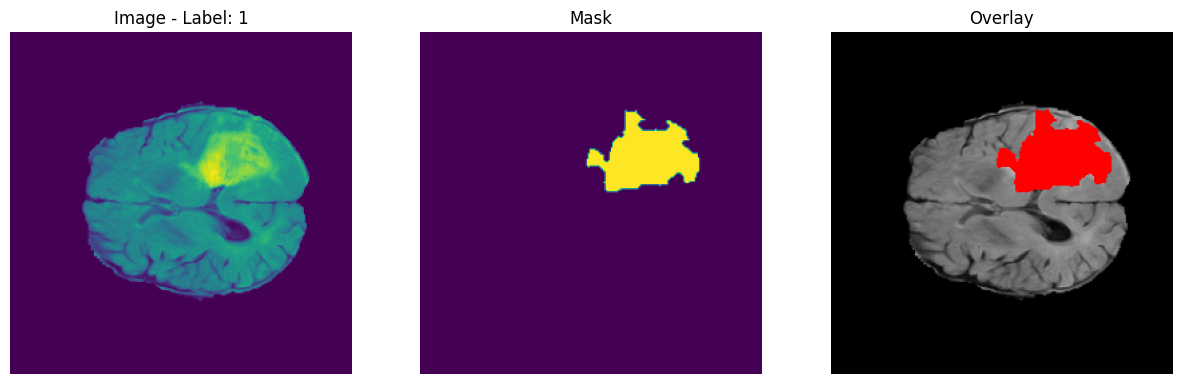

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


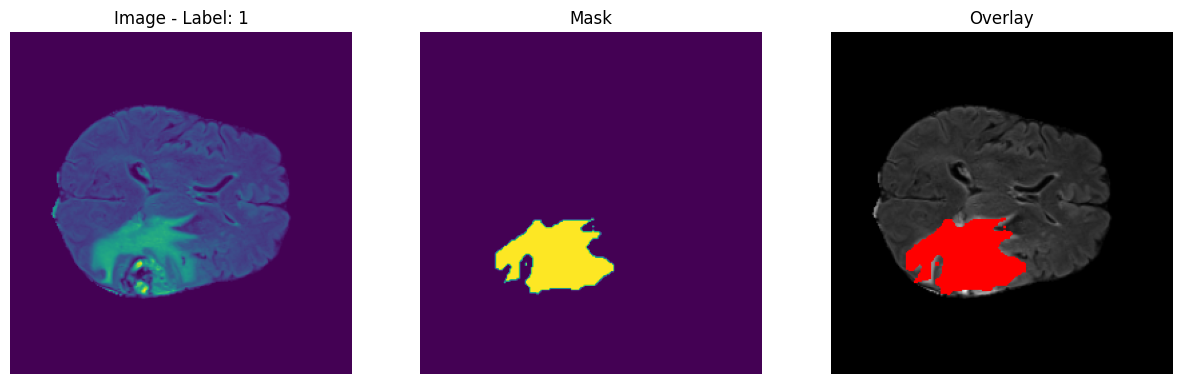

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


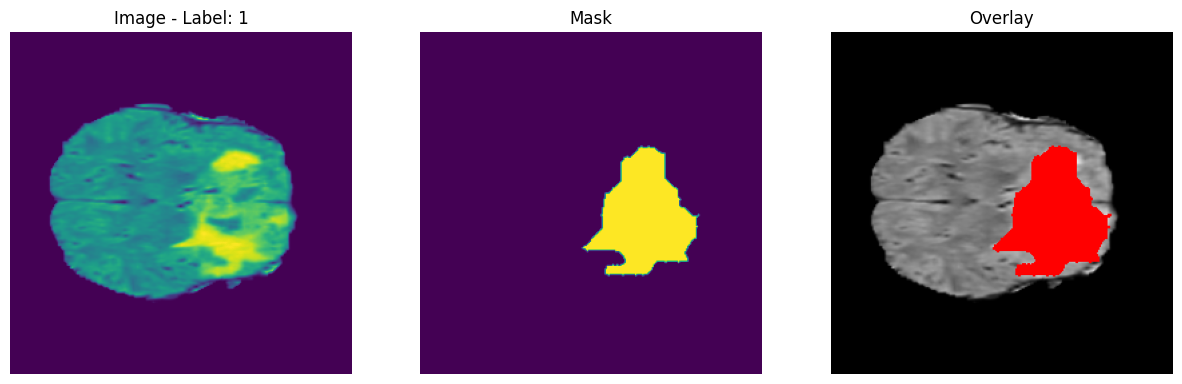

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


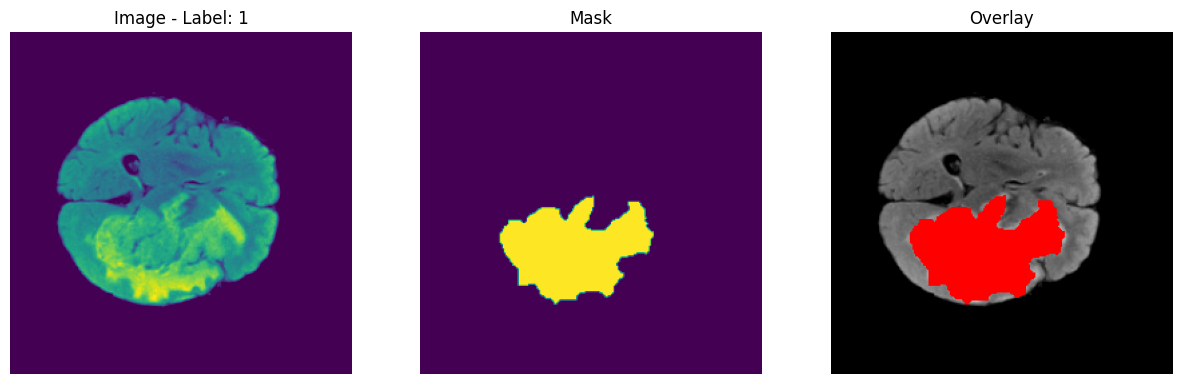

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


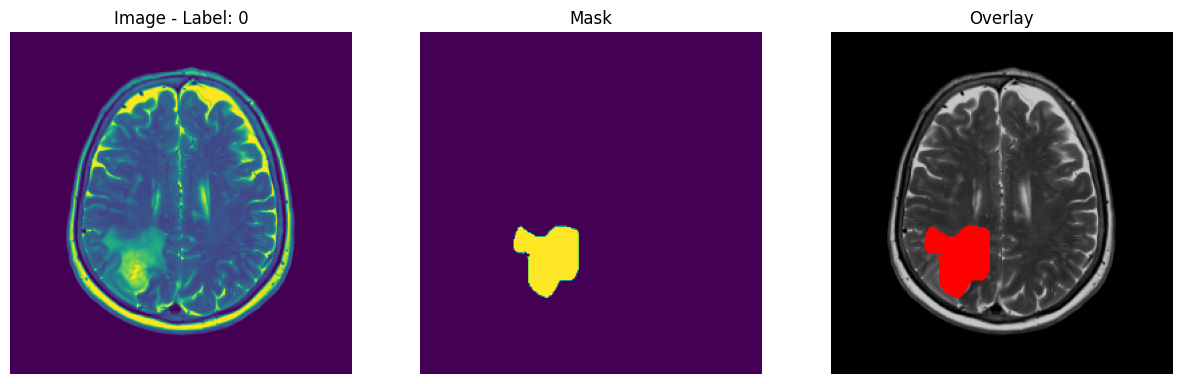

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


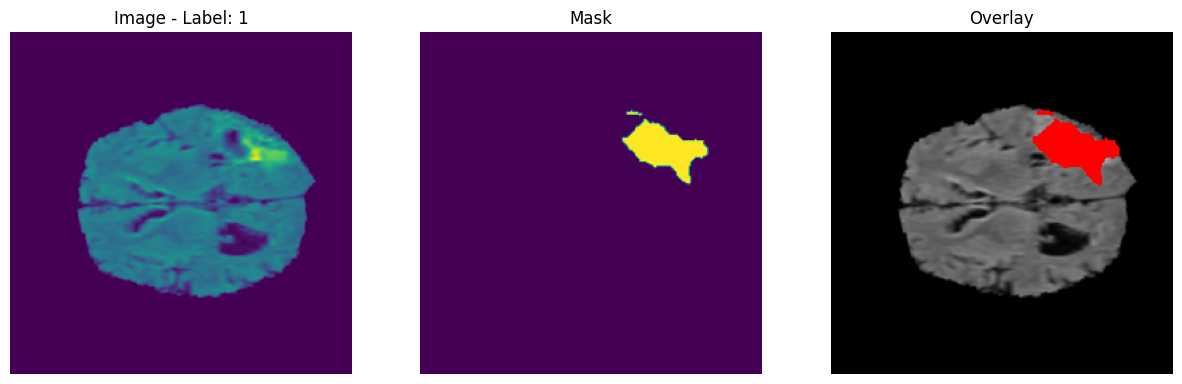

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


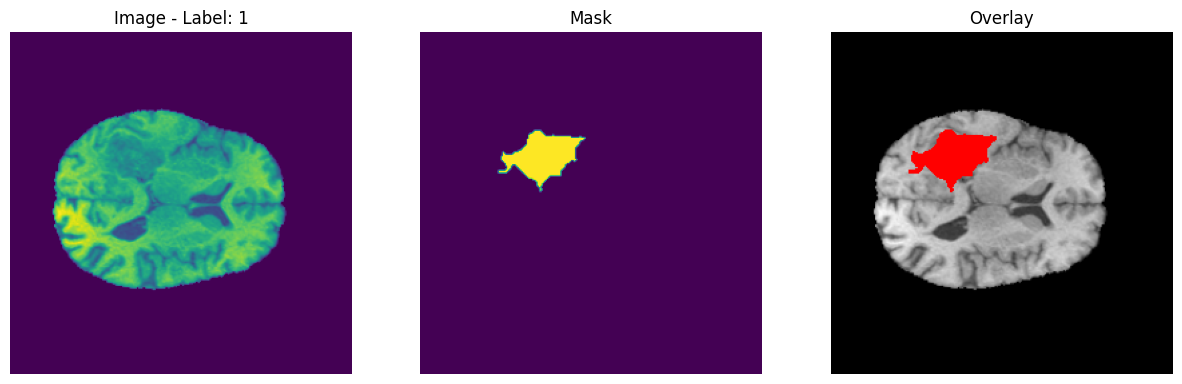

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


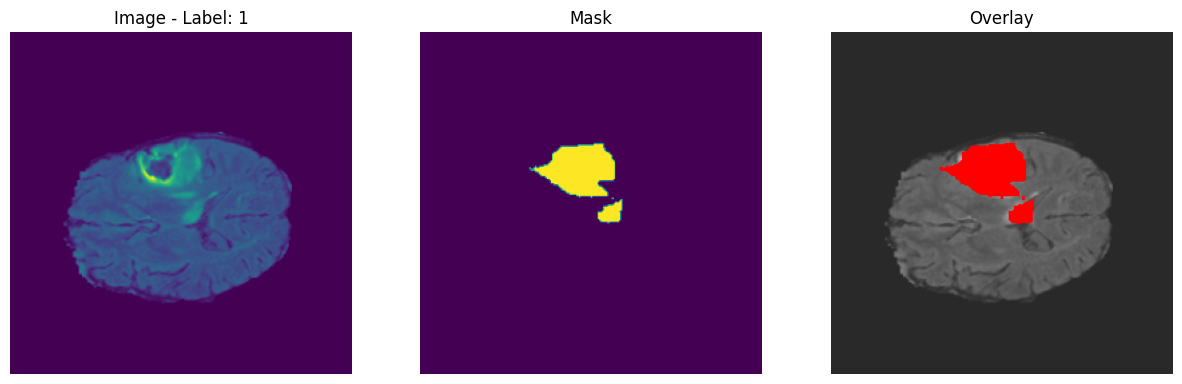

In [16]:
def visualize_batch_with_overlay_and_label(generator, batch_index):
    X_batch, outputs_batch = generator[batch_index]
    num_images = X_batch.shape[0]
    labels = outputs_batch['classification_output']  # Assuming labels are provided here

    for i in range(num_images):
        image = X_batch[i].squeeze()  # Grayscale image, squeeze channel dimension
        mask = outputs_batch['segmentation_output'][i].squeeze()  # Mask corresponding to the image
        label = labels[i]  # Retrieve label for current image

        # Create overlay: Ensure mask is a boolean array for overlay purposes
        overlay = np.where(mask[..., None], np.array([255, 0, 0], dtype=np.uint8), image[..., None])

        plt.figure(figsize=(15, 5))

        # Display original image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f'Image - Label: {label}')
        plt.axis('off')

        # Display mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        # Display overlay
        plt.subplot(1, 3, 3)
        plt.imshow(overlay, cmap='gray')
        plt.title('Overlay')
        plt.axis('off')

        plt.show()

# Example usage
batch_index = 0  # Assuming you want to visualize the first batch
visualize_batch_with_overlay_and_label(train_generator, batch_index)



# Model

In [17]:
(12)

def build_custom_unet_vgg16(input_shape, num_classes_segmentation, num_layers_to_freeze=5):
    inputs = Input(shape=input_shape) 

    def conv_block(input_tensor, num_filters):
        x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(num_filters, (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    def encoder_block(input_tensor, num_filters):
        x = conv_block(input_tensor, num_filters)
        p = MaxPooling2D((2, 2))(x)
        return x, p

    def decoder_block(input_tensor, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
        if skip_features is not None:
            x = Concatenate()([x, skip_features])
        x = conv_block(x, num_filters)
        return x

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    bridge = conv_block(p4, 1024)

    d1 = decoder_block(bridge, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    segmentation_output = Conv2D(num_classes_segmentation, (1, 1), activation="sigmoid", name="segmentation_output")(d4)

    classification_branch = GlobalAveragePooling2D()(d4)
    classification_output = Dense(num_classes_classification, activation="softmax", name="classification_output")(classification_branch)

    # Create the model
    model = Model(inputs=inputs, outputs=[segmentation_output, classification_output], name="Custom_VGG16_U-Net")

    # Debugging
    #print(type(num_layers_to_freeze), num_layers_to_freeze)
    # Degub End
    
    # Freezing Logic (Now at the correct position)
    for layer in model.layers[:num_layers_to_freeze]: 
        layer.trainable = False

    return model



# Inputs
input_shape = (256, 256, 1)  
num_classes_segmentation = 1  
num_classes_classification = 6  

# Phase 1: Initial training for 100 images
model = build_custom_unet_vgg16(input_shape, num_classes_segmentation, num_layers_to_freeze=5) 
    
# Phase 2: More data with 1000 images
# model = build_custom_unet_vgg16(input_shape, num_classes_segmentation, num_layers_to_freeze=3) 

# Phase 3: New class with new class Pituitary tumor
# model = build_custom_unet_vgg16(input_shape, num_classes_segmentation, num_layers_to_freeze=8)

# Building the Model
custom_model = build_custom_unet_vgg16(input_shape, num_classes_segmentation) 
custom_model.summary()



Model: "Custom_VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 256, 256, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 64)         256       ['conv2d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 64)         0         ['batch_nor

Export Model Architecture

In [18]:
# For Displaying Model Architecture and Saving it in PNG Format
# plot_model(custom_model, to_file='custom_unet_vgg16.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=200)

In [19]:
# import visualkeras

# model = custom_model
# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

In [20]:
# import visualkeras
# from PIL import Image, ImageDraw, ImageFont


# # Customize the labels for each layer
# layer_labels = {
#     'input_1': 'Input',
#     'conv2d': 'Conv2D',
#     'max_pooling2d': 'MaxPooling2D',
#     'flatten': 'Flatten',
#     'dense': 'Dense',
#     'output': 'Output'
# }

# # Visualize the model architecture
# vis = visualkeras.layered_view(custom_model, legend=True)

# # Load the image
# img = Image.open(vis)

# # Add labels to the image
# draw = ImageDraw.Draw(img)
# font_size = 12  # Specify the font size
# font_path = "C:\\Windows\\Fonts\\arial.TTF"  # Provide the path to the TrueType font file
# font = ImageFont.truetype(font_path, font_size)

# for layer_name, label in layer_labels.items():
#     layer = vis.layers[layer_name]
#     x = layer['x']
#     y = layer['y']
#     draw.text((x, y), label, fill='black', font=font)

# # Save and display the image
# output_path = 'output_with_labels.png'
# img.save(output_path)
# img.show()


Custom Loss Function

In [21]:
(13)
def focal_tversky_loss(y_true, y_pred, alpha=0.7, gamma=0.75, smooth=1e-6):
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)
    pt_1 = (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)
    return tf.pow((1 - pt_1), gamma)

def boundary_loss(y_true, y_pred):  
    # Morphological Operations for approximate boundary
    kernel = tf.constant([[1,1,1], [1,-8,1], [1,1,1]]) 
    y_true_boundary = tf.nn.conv2d(y_true, kernel, strides=[1,1,1,1], padding="SAME")
    y_pred_boundary = tf.nn.conv2d(y_pred, kernel, strides=[1,1,1,1], padding="SAME")

    boundary_loss = tf.reduce_mean(tf.abs(y_true_boundary - y_pred_boundary))
    return boundary_loss  

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    cross_entropy = -y_true * tf.math.log(y_pred) 
    weight = alpha * y_true * tf.pow((1 - y_pred), gamma) 

    focal_loss = weight * cross_entropy
    focal_loss = tf.reduce_mean(focal_loss)
    return focal_loss

def combined_loss(y_true, y_pred):
    y_true_seg, y_true_class = y_true
    y_pred_seg, y_pred_class = y_pred

    loss_seg = focal_tversky_loss(y_true_seg, y_pred_seg) + boundary_loss(y_true_seg, y_pred_seg) 
    loss_class = focal_loss(y_true_class, y_pred_class)

    # Simple combination with equal weights
    total_loss = 0.5 * loss_seg + 0.5 * loss_class  
    return total_loss


In [22]:
def get_latest_dice_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.bool)  # Ensure binary format
    y_pred = tf.cast(y_pred > 0.5, tf.bool)  # Threshold and convert to boolean

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_score = (2. * intersection) / (union + tf.keras.backend.epsilon())

    return dice_score


In [23]:
class DynamicWeightingCallback(Callback):
    def __init__(self, threshold=0.80, val_data=None):  # Add val_data
        super().__init__() 
        self.threshold = threshold
        self.val_data = val_data  # Store validation data

    def on_epoch_begin(self, epoch, logs=None):
        y_true_val, y_pred_val = self.val_data  # Fetch from stored data
        current_dice = get_latest_dice_score(y_true_val, y_pred_val) 
    
        if current_dice < self.threshold: 
            weight_seg = 0.7
            weight_class = 0.3
        else:
            weight_seg = 0.5
            weight_class = 0.5

        # Update loss weights within your model (Important!)
        custom_model.loss_weights = [weight_seg, weight_class] 


In [24]:
dynamic_weighting = DynamicWeightingCallback(threshold=0.80, val_data=val_generator) 


Checkpoints

In [25]:
(14)
checkpoint_filepath = 'Model_Weights/model_checkpoint.keras'
csv_logger_filepath = 'Model_Weights/training_log.csv'

# Save the entire model, not just weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_total_loss',  # Monitor validation total_loss
    mode='min',
    save_weights_only=False,  
    verbose=1)

# Early stopping based on total_loss
early_stopping = EarlyStopping(
    monitor='val_total_loss', 
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True)

# CSV Logging with total_loss
csv_logger = CSVLogger(csv_logger_filepath, append=True)

# Reduce LR based on total_loss
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_total_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=0.00001)

callbacks = [
    model_checkpoint_callback, 
    early_stopping, 
    csv_logger, 
    reduce_lr_callback
]


In [26]:
(15)
custom_objects = {
    'focal_tversky_loss': focal_tversky_loss, 
    'boundary_loss': boundary_loss,
    'focal_loss': focal_loss,
    'combined_loss': combined_loss  
 }


Loading

In [27]:
(16)
# Paths to model and CSV file
model_path = 'Model_Weights/model_checkpoint.keras'
history_csv_path = 'Model_Weights/training_log.csv'

# Load model if it exists, create a new one otherwise
if os.path.exists(model_path):
    try:
        custom_model = load_model(model_path)  # You might need to add 'custom_objects' here
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Creating a new one.")
        custom_model = build_custom_unet_vgg16(input_shape, num_classes_segmentation)
else:
    print("No existing model found. Creating a new one.")
    custom_model = build_custom_unet_vgg16(input_shape, num_classes_segmentation)

# Initialize CSV if it doesn't exist, otherwise load existing data
if not os.path.exists(history_csv_path):
    print("Creating a new CSV file for training history.")
    columns = ['epoch', 'focal_tversky_loss', 'boundary_loss', 'focal_loss', 'combined_loss'] 
    df = pd.DataFrame(columns=columns)
    df.to_csv(history_csv_path, index=False)
else:
    print("CSV file for training history exists.")
    df = pd.read_csv(history_csv_path) 


No existing model found. Creating a new one.
CSV file for training history exists.


Compile

In [28]:
(17)
# Compile the custom model
custom_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=combined_loss,
    metrics={'segmentation_output': ['accuracy'], 
             'classification_output': ['accuracy']}
)

In [29]:
# Create callback instance
dynamic_weighting = DynamicWeightingCallback() 

Epochs

In [30]:
(18)
# Training with History Saving
history = custom_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,  
    callbacks=callbacks,  
    verbose=1
)

# Save the updated history after training
df = pd.DataFrame(history.history) 
df.to_csv(history_csv_path, index=False) 


Epoch 1/100



OperatorNotAllowedInGraphError: in user code:

    File "C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Implici7\AppData\Local\Temp\ipykernel_3596\3533363534.py", line 30, in combined_loss  *
        y_true_seg, y_true_class = y_true

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.


# Predictions

model loading

In [21]:
# Load the trained model
model_path = 'Model_Weights/model_checkpoint.keras'
try:
    loaded_model = load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Model not available.")
    loaded_model = None


Model loaded successfully.


Model Prediction Display of segmentation

In [24]:
# Function to preprocess the input image
def preprocess_image(image_path, target_size):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = np.expand_dims(img, axis=-1)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to predict mask using the loaded model
def predict_mask(model, image_path, target_size):
    img = preprocess_image(image_path, target_size)
    mask = model.predict(img)
    # Assuming the model predicts multiple outputs (segmentation and classification), 
    # and you want the segmentation output
    return mask[0].squeeze()  # Extracting the segmentation output and remove the batch dimension


# Target size for input images (should match the input shape of your model)
target_size = (256, 256)

# Randomly select 5 images from final_df
random_indices = random.sample(range(len(final_df)), 5)
selected_images = final_df.iloc[random_indices]


In [ ]:

# # Define a function to display images and masks
# def display_image_with_masks(image, original_mask, predicted_mask, title):
#     plt.figure(figsize=(15, 5))

#     plt.subplot(1, 3, 1)
#     plt.imshow(image, cmap='gray')
#     plt.title('Original Image')
#     plt.axis('off')

#     plt.subplot(1, 3, 2)
#     plt.imshow(original_mask, cmap='jet')  # Display the original mask with a color map
#     plt.title('Original Mask')
#     plt.axis('off')

#     plt.subplot(1, 3, 3)
#     plt.imshow(predicted_mask, cmap='jet')  # Display the predicted mask with a color map
#     plt.title('Predicted Mask')
#     plt.axis('off')

#     plt.suptitle(title)
#     plt.show()

# # Predict masks for the selected images and display them using Matplotlib
# for index, row in selected_images.iterrows():
#     image_path = row['Image_Path']
#     predicted_mask = predict_mask(loaded_model, image_path, target_size)
    
#     # Load the original image and its corresponding mask
#     original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     original_mask_path = row['Mask_Path']
#     original_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)

#     # Display the image and both masks
#     display_image_with_masks(original_image, original_mask, predicted_mask, f'Image {index}')

1/1 [==============================] - 1s 843ms/step
Original Image Shape: (630, 630, 3)
Predicted Mask Shape: (256, 256)


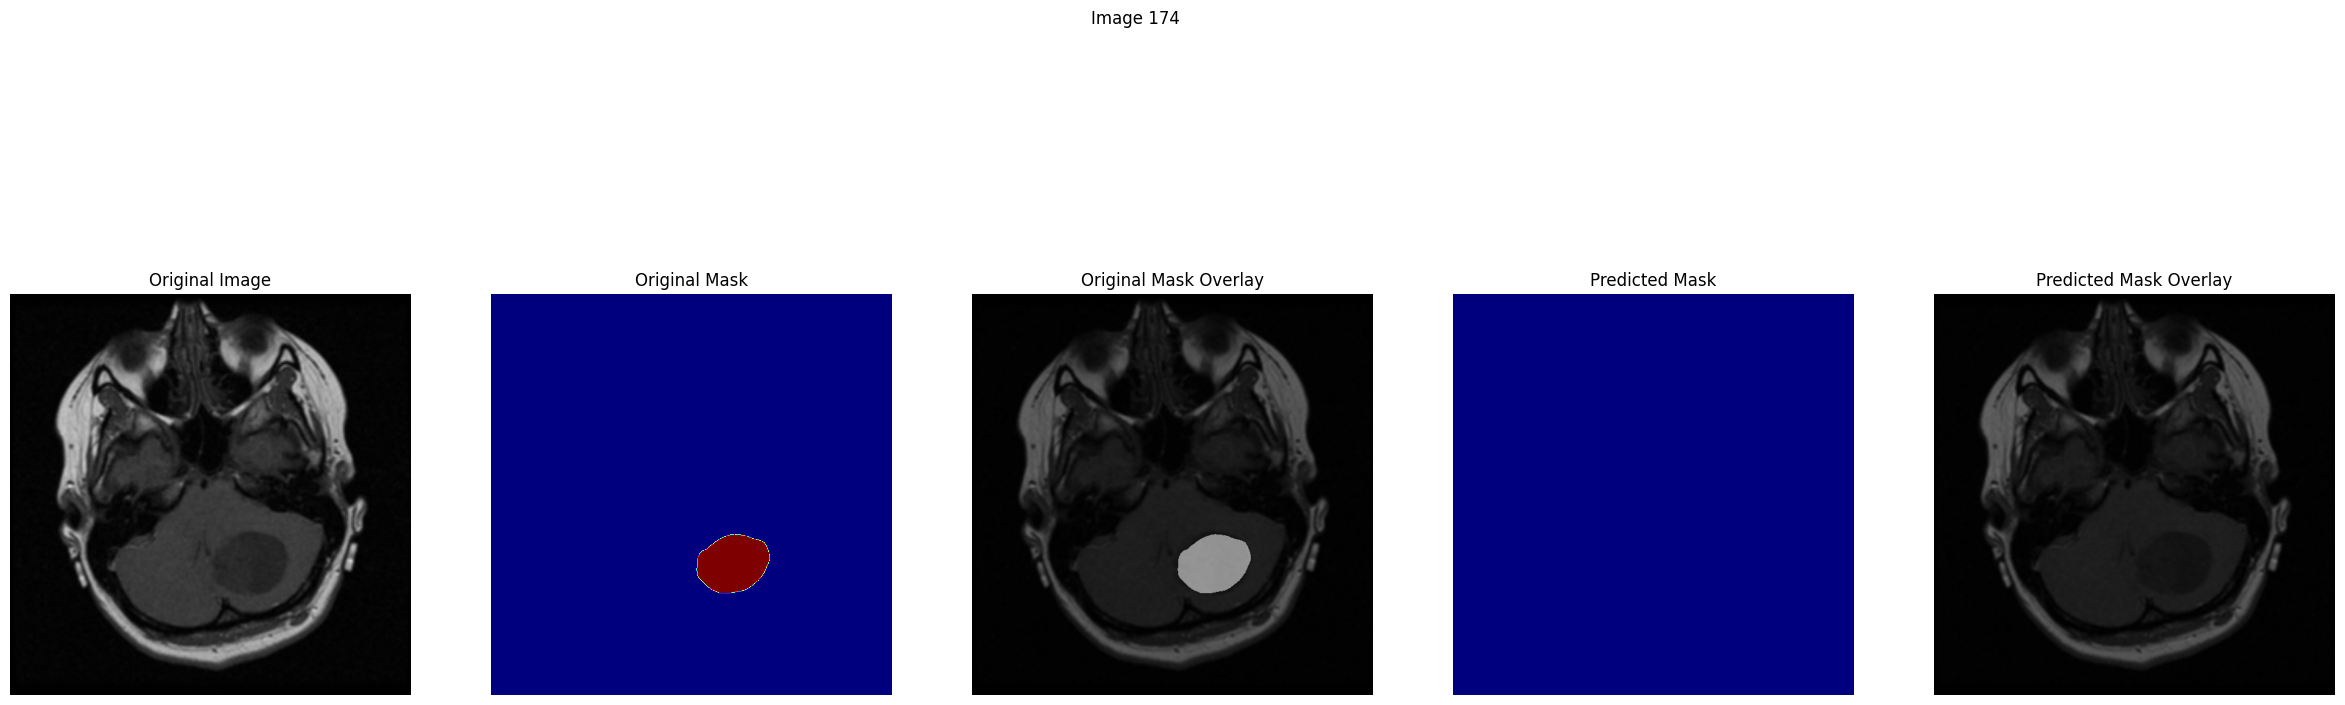

1/1 [==============================] - 0s 299ms/step
Original Image Shape: (256, 256, 3)
Predicted Mask Shape: (256, 256)


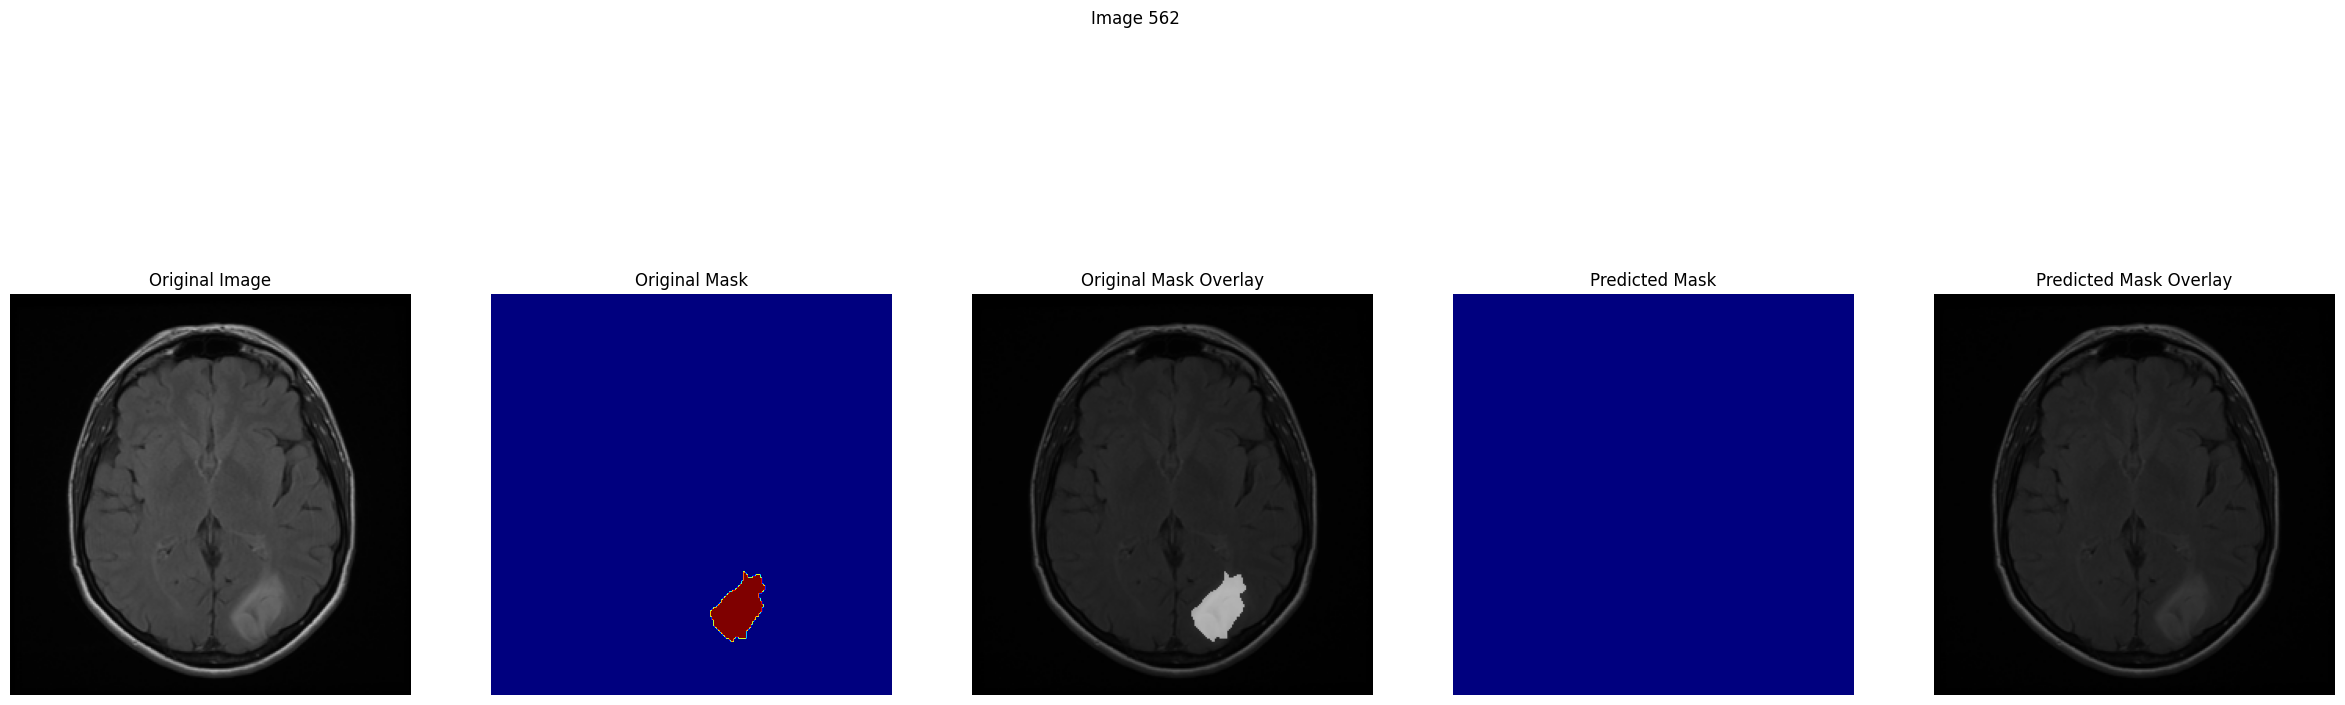

1/1 [==============================] - 0s 285ms/step
Original Image Shape: (589, 489, 3)
Predicted Mask Shape: (256, 256)


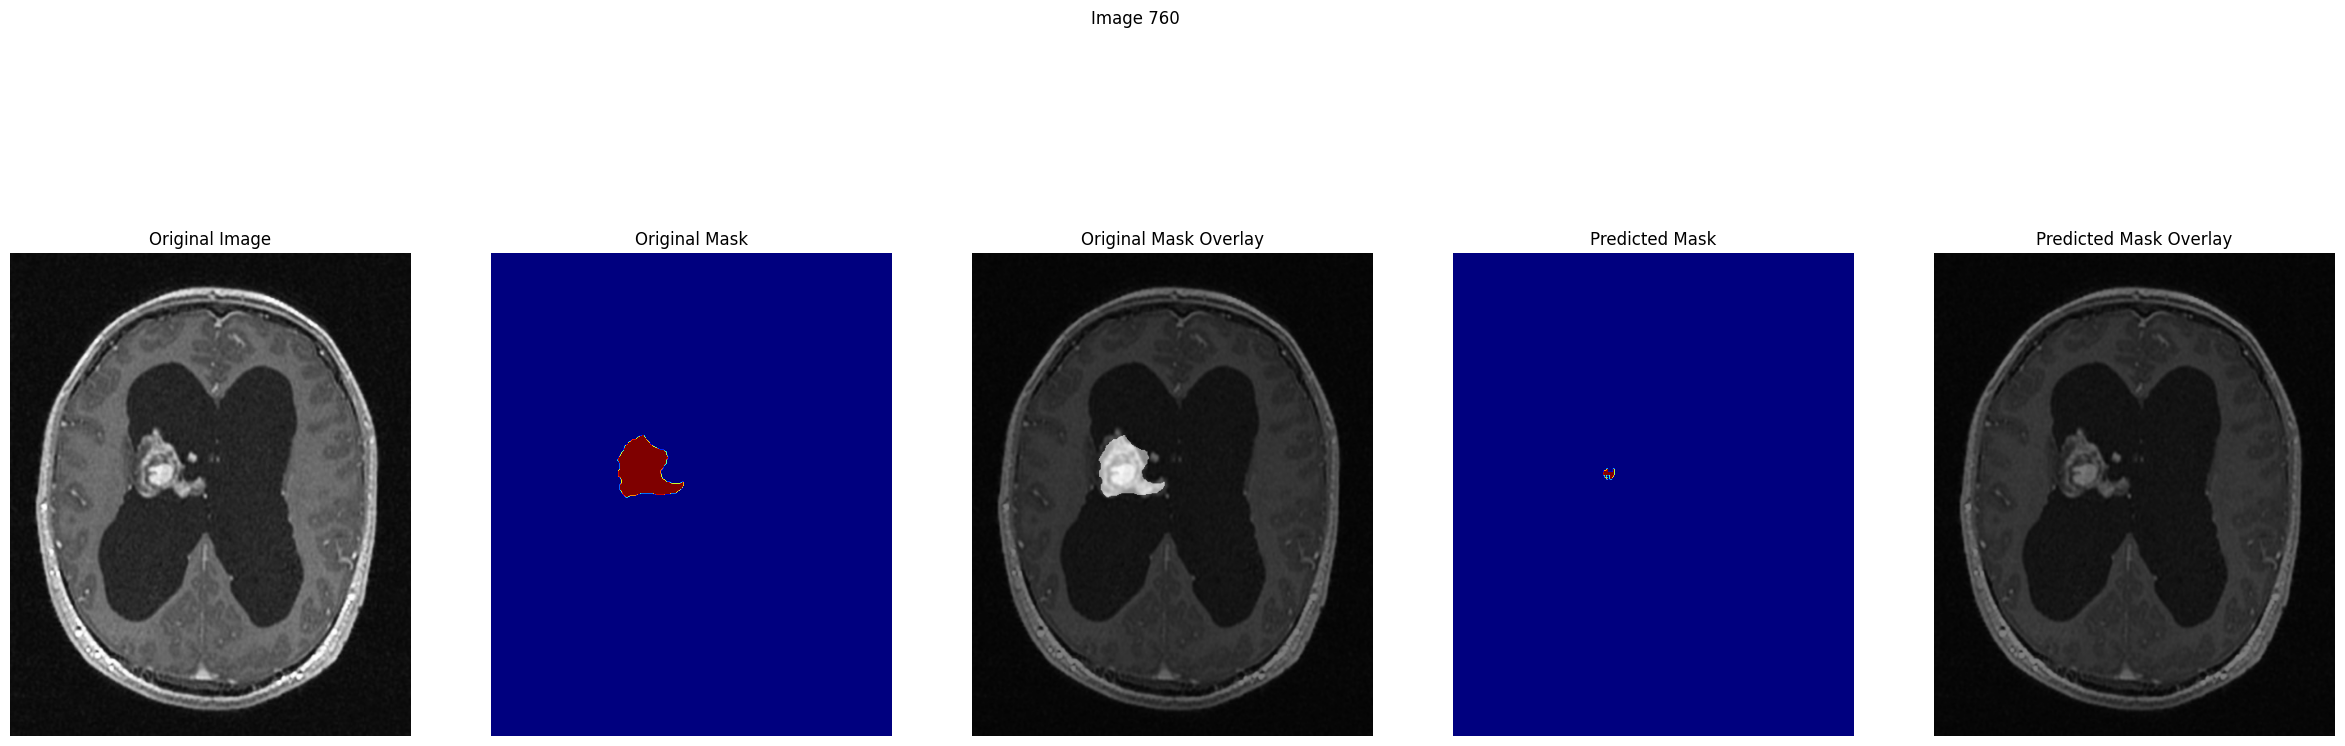

1/1 [==============================] - 0s 300ms/step
Original Image Shape: (589, 489, 3)
Predicted Mask Shape: (256, 256)


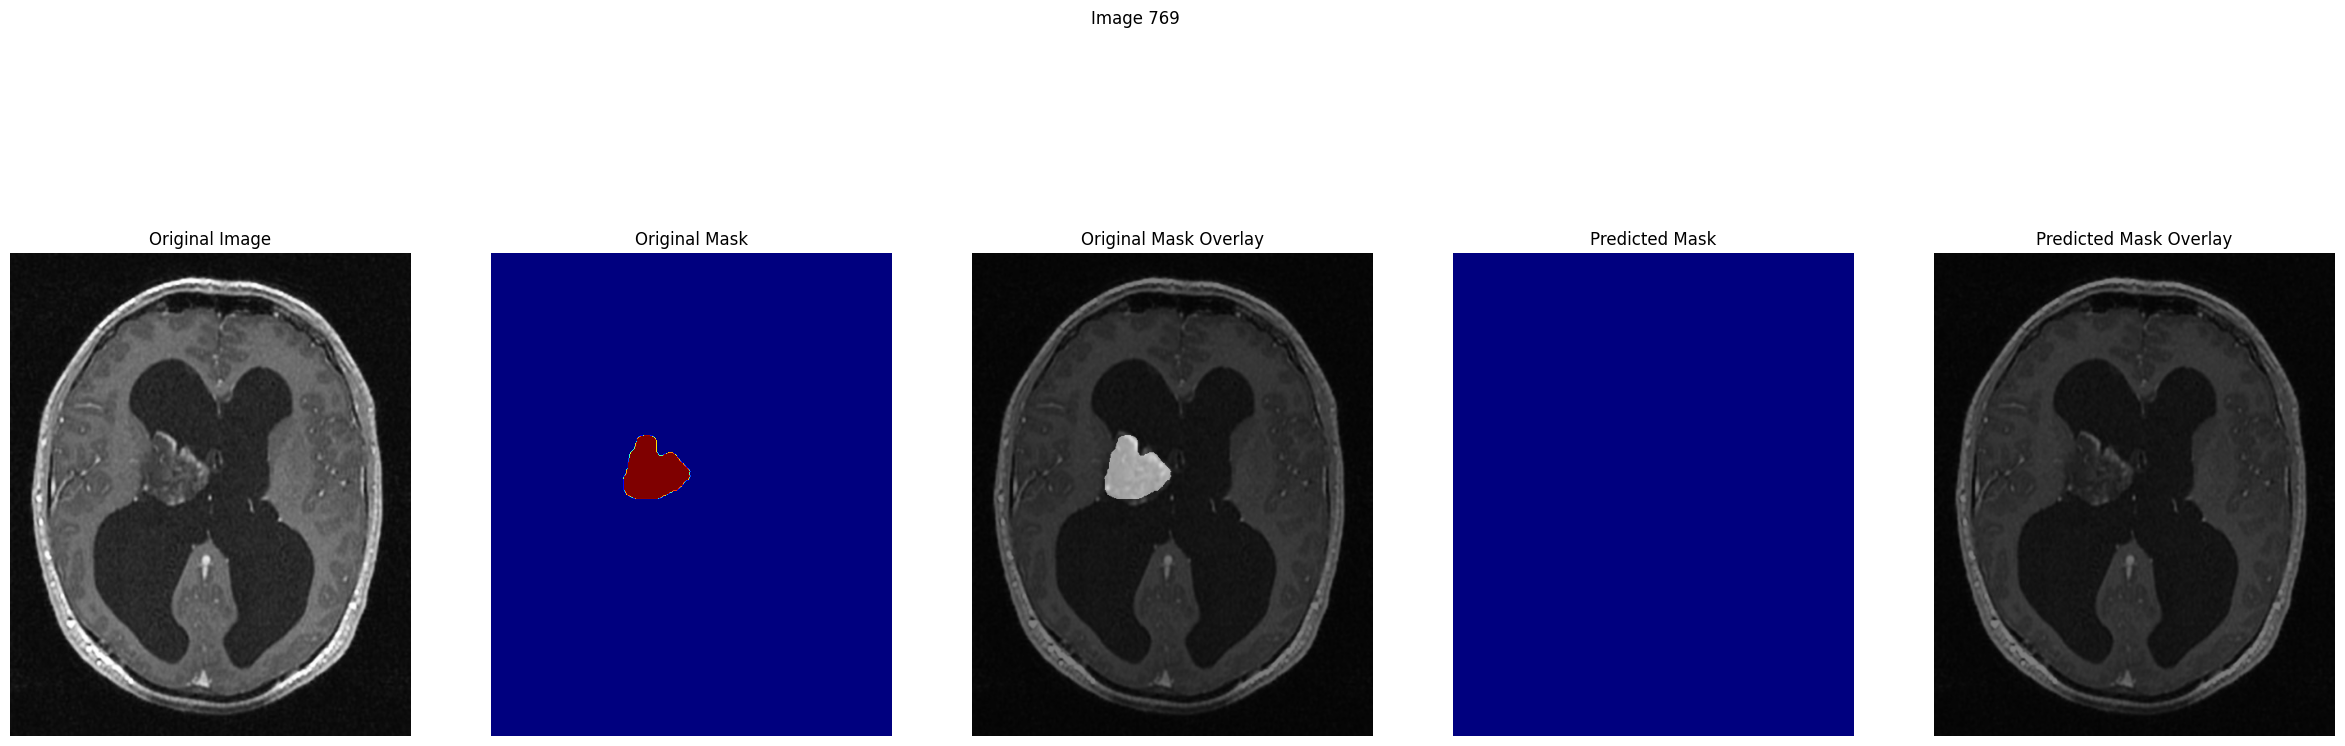

1/1 [==============================] - 0s 309ms/step
Original Image Shape: (630, 553, 3)
Predicted Mask Shape: (256, 256)


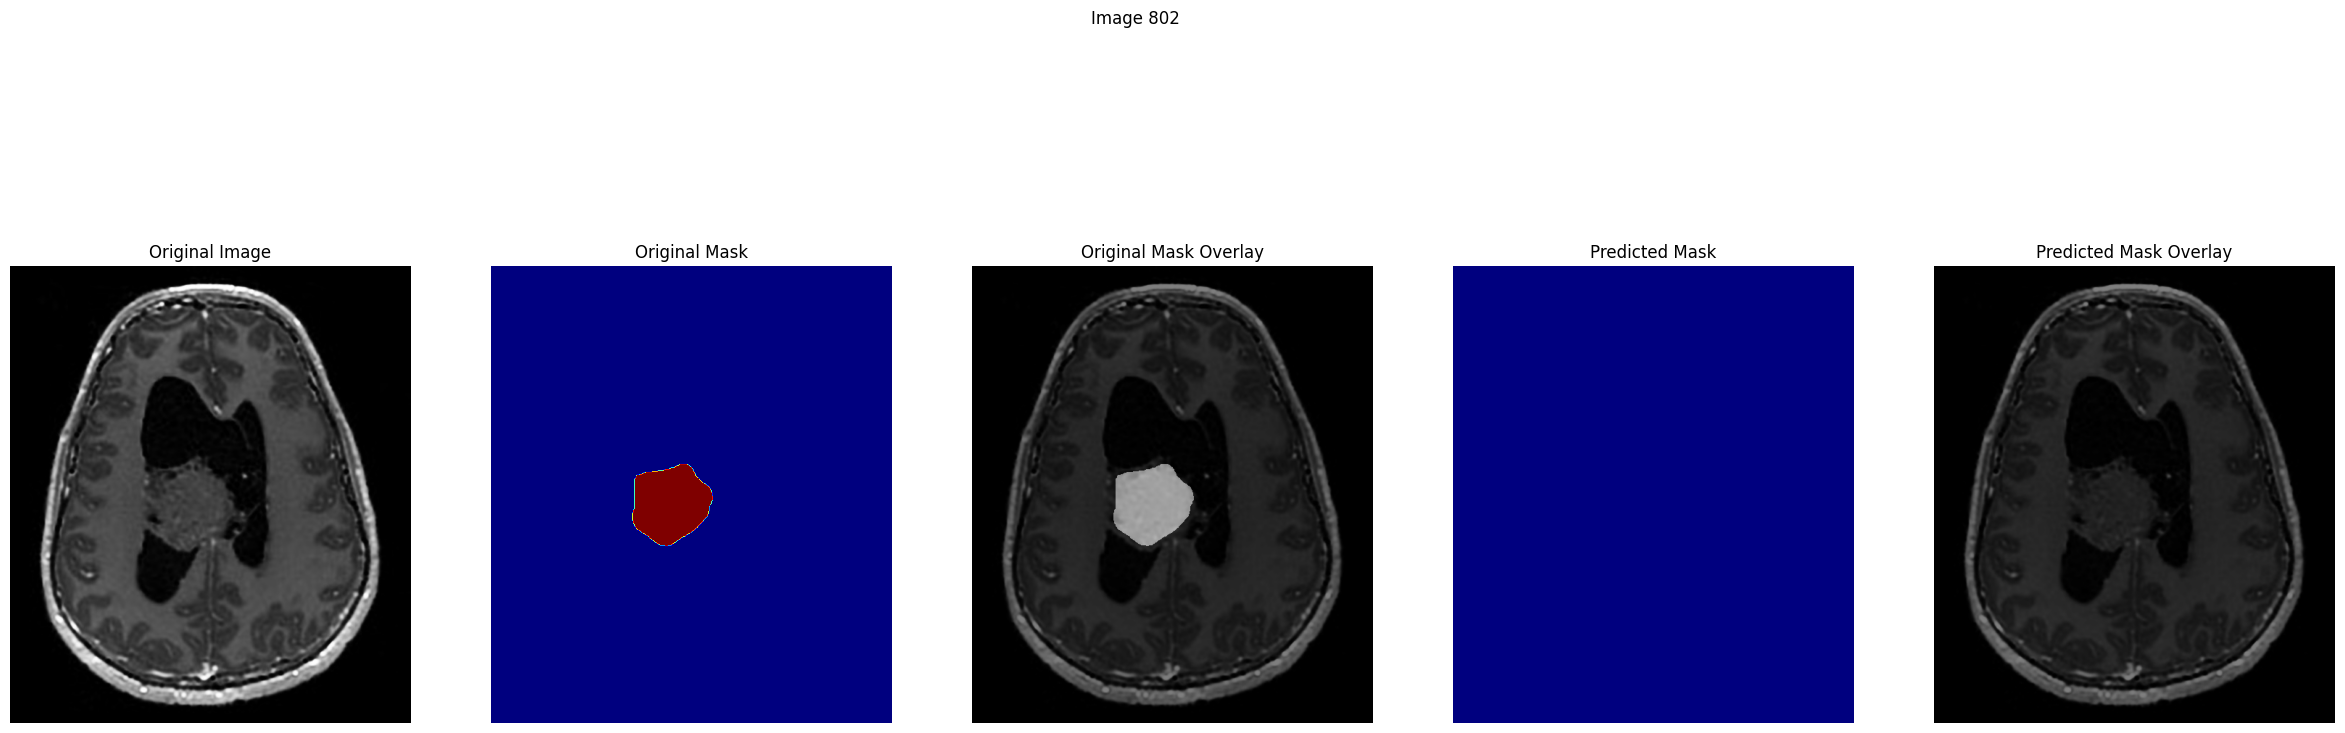

In [25]:
# Modify the display_images_with_overlay_masks function to remove resizing of the original image
def display_images_with_overlay_masks(original_image, original_mask, predicted_mask, title, image_path):
    # Convert grayscale image to RGB for visualization
    if len(original_image.shape) == 2:
        original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)

    # Predict the mask using the loaded model
    predicted_mask = predict_mask(loaded_model, image_path, target_size)

    print("Original Image Shape:", original_image.shape)
    print("Predicted Mask Shape:", predicted_mask.shape)

    # Resize the predicted mask for visualization
    predicted_mask_resized = cv2.resize(predicted_mask, (original_image.shape[1], original_image.shape[0]))

    # Convert the predicted mask to the same type as the original image
    predicted_mask_resized = predicted_mask_resized.astype(np.uint8)

    # Create overlay images
    original_mask_overlay = cv2.addWeighted(original_image, 0.5, cv2.cvtColor(original_mask, cv2.COLOR_GRAY2RGB), 0.5, 0)
    predicted_mask_overlay = cv2.addWeighted(original_image, 0.5, cv2.cvtColor(predicted_mask_resized, cv2.COLOR_GRAY2RGB), 0.5, 0)

    plt.figure(figsize=(30, 10))

    # Display original image
    plt.subplot(1, 5, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Display original mask
    plt.subplot(1, 5, 2)
    plt.imshow(original_mask, cmap='jet')
    plt.title('Original Mask')
    plt.axis('off')

    # Display original mask overlay with original image
    plt.subplot(1, 5, 3)
    plt.imshow(original_mask_overlay)
    plt.title('Original Mask Overlay')
    plt.axis('off')

    # Display predicted mask
    plt.subplot(1, 5, 4)
    plt.imshow(predicted_mask_resized, cmap='jet')
    plt.title('Predicted Mask')
    plt.axis('off')

    # Display predicted mask overlay with original image
    plt.subplot(1, 5, 5)
    plt.imshow(predicted_mask_overlay)
    plt.title('Predicted Mask Overlay')
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Predict masks for the selected images
for index, row in selected_images.iterrows():
    image_path = row['Image_Path']
    original_mask_path = row['Mask_Path']
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Display the images with overlay masks
    display_images_with_overlay_masks(original_image, original_mask, None, f'Image {index}', image_path)


# Graphs

loss graphs

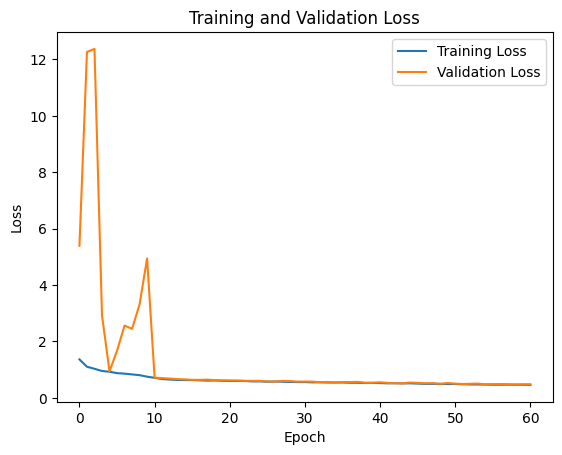

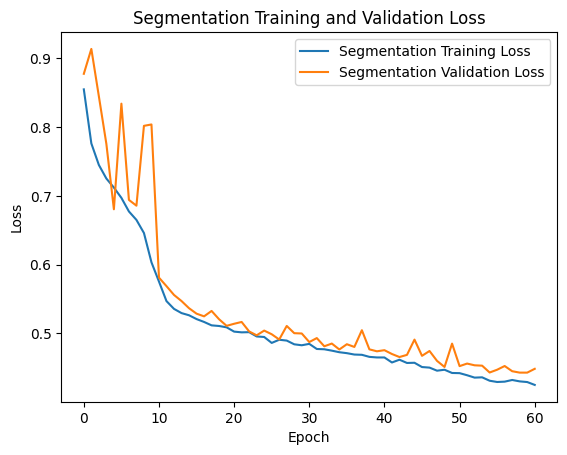

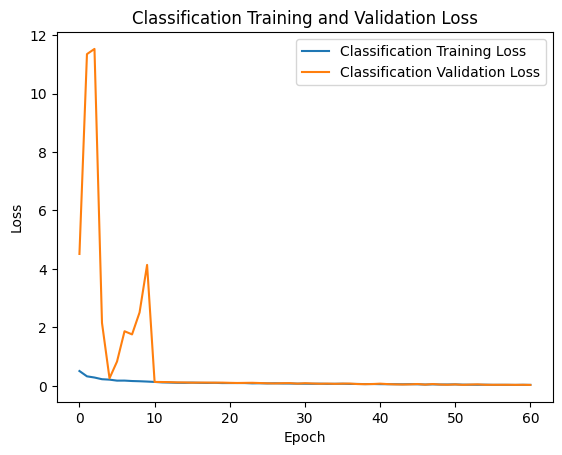

In [26]:
# Read the training history CSV file
history_df = pd.read_csv(history_csv_path)

# Plot training and validation losses
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot segmentation output losses
plt.plot(history_df['segmentation_output_loss'], label='Segmentation Training Loss')
plt.plot(history_df['val_segmentation_output_loss'], label='Segmentation Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Segmentation Training and Validation Loss')
plt.legend()
plt.show()

# Plot classification output losses
plt.plot(history_df['classification_output_loss'], label='Classification Training Loss')
plt.plot(history_df['val_classification_output_loss'], label='Classification Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Training and Validation Loss')
plt.legend()
plt.show()


accuracy graphs

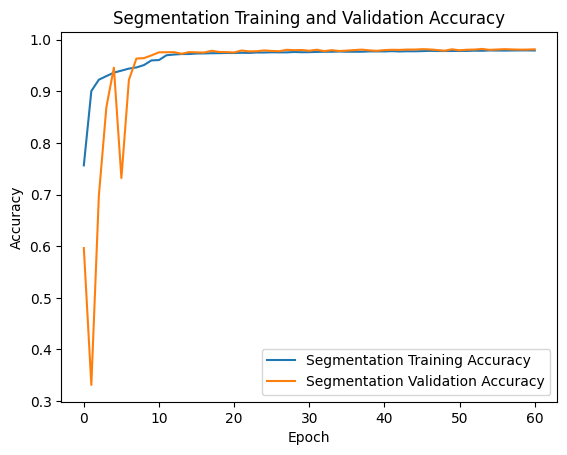

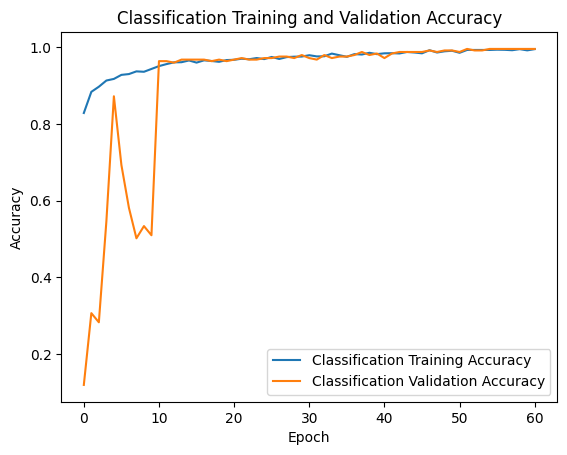

In [27]:
# Plot segmentation output accuracies
plt.plot(history_df['segmentation_output_accuracy'], label='Segmentation Training Accuracy')
plt.plot(history_df['val_segmentation_output_accuracy'], label='Segmentation Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Segmentation Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot classification output accuracies
plt.plot(history_df['classification_output_accuracy'], label='Classification Training Accuracy')
plt.plot(history_df['val_classification_output_accuracy'], label='Classification Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Training and Validation Accuracy')
plt.legend()
plt.show()


something testing

# F1 Score

F1 Score for segmentation

In [28]:
# Generate predictions for the validation set
val_predictions = []

# Iterate over the validation generator to collect predictions
for i in range(len(val_generator)):
    batch_images, batch_masks = val_generator[i]
    batch_predictions = custom_model.predict(batch_images)
    val_predictions.extend(batch_predictions)

# Threshold the predicted masks (assuming binary segmentation)
threshold = 0.5
val_predictions_thresholded = [(pred > threshold).astype(np.uint8) for pred in val_predictions]

# Flatten the true masks and predicted masks
true_masks_flat = np.concatenate([val_generator[i][1]['segmentation_output'].flatten() for i in range(len(val_generator))])

# Apply threshold to true masks
true_masks_thresholded = (true_masks_flat > threshold).astype(np.uint8)

# Flatten the predicted masks
predicted_masks_flat = np.concatenate([mask.flatten() for mask in val_predictions_thresholded])

# Ensure the lengths are consistent
min_length = min(len(true_masks_thresholded), len(predicted_masks_flat))
true_masks_thresholded = true_masks_thresholded[:min_length]
predicted_masks_flat = predicted_masks_flat[:min_length]

# Compute F1 score for segmentation
f1_segmentation = f1_score(true_masks_thresholded, predicted_masks_flat)

print("F1 Score for Segmentation:", f1_segmentation)


1/1 [==============================] - 4s 4s/step
F1 Score for Segmentation: 0.3056571933895294


F1 score for classification

In [70]:
# Generate predictions for the validation set
val_predictions = []

# Iterate over the validation generator to collect predictions
for i in range(len(val_generator)):
    batch_images, batch_masks = val_generator[i]
    batch_predictions = custom_model.predict(batch_images)
    val_predictions.extend(batch_predictions)

# Threshold the predicted masks (assuming binary segmentation)
threshold = 0.5
val_predictions_thresholded = [(pred > threshold).astype(np.uint8) for pred in val_predictions]

# Flatten the true masks and predicted masks
true_masks_flat = np.concatenate([val_generator[i][1]['classification_output'].flatten() for i in range(len(val_generator))])

# Apply threshold to true masks
true_masks_thresholded = (true_masks_flat > threshold).astype(np.uint8)

# Flatten the predicted masks
predicted_masks_flat = np.concatenate([mask.flatten() for mask in val_predictions_thresholded])

# Ensure the lengths are consistent
min_length = min(len(true_masks_thresholded), len(predicted_masks_flat))
true_masks_thresholded = true_masks_thresholded[:min_length]
predicted_masks_flat = predicted_masks_flat[:min_length]

# Compute F1 score for segmentation
f1_segmentation = f1_score(true_masks_thresholded, predicted_masks_flat)

print("F1 Score for Classification:", f1_segmentation)


1/1 [==============================] - 3s 3s/step
F1 Score for Classification: 0.0


# Precision and Recall

for segmentation

In [31]:
# Generate predictions for the validation set
val_predictions = []

# Iterate over the validation generator to collect predictions
for i in range(len(val_generator)):
    batch_images, batch_masks = val_generator[i]
    batch_predictions = custom_model.predict(batch_images)
    val_predictions.extend(batch_predictions)

# Threshold the predicted masks (assuming binary segmentation)
threshold = 0.5
val_predictions_thresholded = [(pred > threshold).astype(np.uint8) for pred in val_predictions]

# Flatten the true masks and predicted masks
true_masks_flat = np.concatenate([val_generator[i][1]['segmentation_output'].flatten() for i in range(len(val_generator))])

# Apply threshold to true masks
true_masks_thresholded = (true_masks_flat > threshold).astype(np.uint8)

# Flatten the predicted masks
predicted_masks_flat = np.concatenate([mask.flatten() for mask in val_predictions_thresholded])

# Ensure the lengths are consistent
min_length = min(len(true_masks_thresholded), len(predicted_masks_flat))
true_masks_thresholded = true_masks_thresholded[:min_length]
predicted_masks_flat = predicted_masks_flat[:min_length]

# Compute precision and recall
precision = precision_score(true_masks_thresholded, predicted_masks_flat)
recall = recall_score(true_masks_thresholded, predicted_masks_flat)

print("Precision:", precision)
print("Recall:", recall)


1/1 [==============================] - 3s 3s/step
Precision: 0.2981749398505762
Recall: 0.3135246242697602


for classification

In [68]:
# Flatten the true labels
true_labels_flat = []
for _, label in val_generator:
    true_labels_flat.extend(label)

# Check if predictions are generated
if val_predictions:
    # Flatten the predicted labels
    predicted_labels_flat = []
    for pred in val_predictions:
        predicted_labels_flat.extend(np.argmax(pred, axis=-1))

    # Convert lists to numpy arrays
    true_labels_flat = np.array(true_labels_flat)
    predicted_labels_flat = np.array(predicted_labels_flat)

    # Compute precision and recall
    precision = precision_score(true_labels_flat, predicted_labels_flat, average='macro')
    recall = recall_score(true_labels_flat, predicted_labels_flat, average='macro')

    # Print precision and recall
    print("Precision:", precision)
    print("Recall:", recall)
else:
    print("No predictions generated.")


No predictions generated.


In [57]:
# Generate predictions for the validation set
val_predictions = []

# Iterate over the validation generator to collect predictions
for i in range(len(val_generator)):
    batch_images, batch_masks = val_generator[i]
    batch_predictions = custom_model.predict(batch_images)
    val_predictions.extend(batch_predictions)

# Threshold the predicted masks (assuming binary segmentation)
threshold = 0.5
val_predictions_thresholded = [(pred > threshold).astype(np.uint8) for pred in val_predictions]

# Flatten the true masks and predicted masks
true_masks_flat = np.concatenate([val_generator[i][1]['classification_output'].flatten() for i in range(len(val_generator))])

# Apply threshold to true masks
true_masks_thresholded = (true_masks_flat > threshold).astype(np.uint8)

# Flatten the predicted masks
predicted_masks_flat = np.concatenate([mask.flatten() for mask in val_predictions_thresholded])

# Ensure the lengths are consistent
min_length = min(len(true_masks_thresholded), len(predicted_masks_flat))
true_masks_thresholded = true_masks_thresholded[:min_length]
predicted_masks_flat = predicted_masks_flat[:min_length]

# Compute precision and recall
precision = precision_score(true_masks_thresholded, predicted_masks_flat)
recall = recall_score(true_masks_thresholded, predicted_masks_flat)

print("Precision:", precision)
print("Recall:", recall)


1/1 [==============================] - 3s 3s/step
Precision: 0.0
Recall: 0.0


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion Matrix

Confusion Matrix - Segmentation

1/1 [==============================] - 3s 3s/step


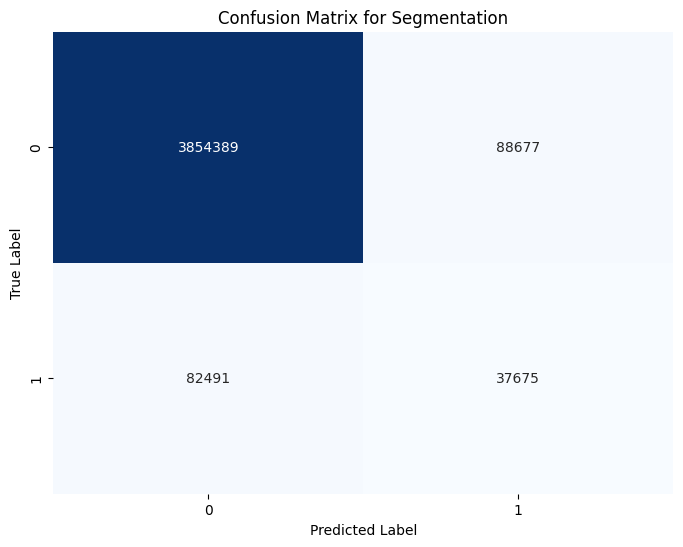

In [40]:
# Generate predictions for the validation set
val_predictions = []

# Iterate over the validation generator to collect predictions
for i in range(len(val_generator)):
    batch_images, batch_masks = val_generator[i]
    batch_predictions = custom_model.predict(batch_images)
    val_predictions.extend(batch_predictions)

# Threshold the predicted masks (assuming binary segmentation)
threshold = 0.5
val_predictions_thresholded = [(pred > threshold).astype(np.uint8) for pred in val_predictions]

# Flatten the true masks and predicted masks
true_masks_flat = np.concatenate([val_generator[i][1]['segmentation_output'].flatten() for i in range(len(val_generator))])

# Apply threshold to true masks
true_masks_thresholded = (true_masks_flat > threshold).astype(np.uint8)

# Flatten the predicted masks
predicted_masks_flat = np.concatenate([mask.flatten() for mask in val_predictions_thresholded])

# Ensure the lengths are consistent
min_length = min(len(true_masks_thresholded), len(predicted_masks_flat))
true_masks_thresholded = true_masks_thresholded[:min_length]
predicted_masks_flat = predicted_masks_flat[:min_length]

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_masks_thresholded, predicted_masks_flat)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Segmentation')
plt.show()

Confusion Matrix - classification

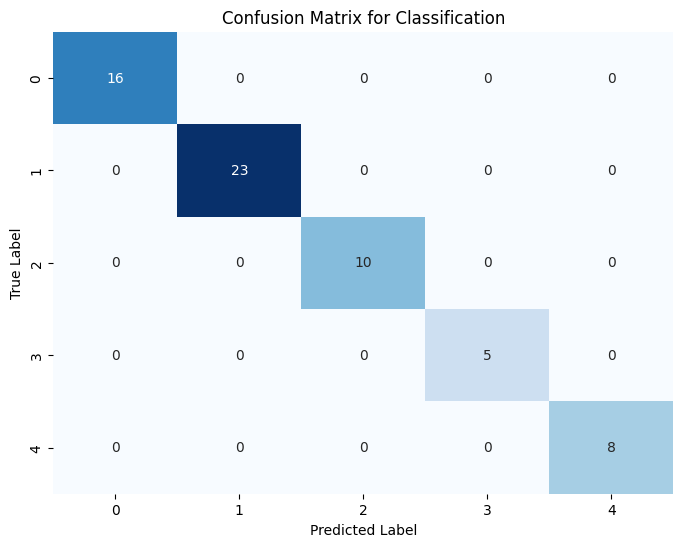

In [37]:
# Extract the classification predictions from the model's output
classification_predictions = val_predictions[1]

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(classification_predictions, axis=1)

# Flatten the true labels
true_labels_flat = np.concatenate([val_generator[i][1]['classification_output'] for i in range(len(val_generator))])

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels_flat, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Classification')
plt.show()


# Combined Precision,Recall and F1 Score

In [75]:
from sklearn.metrics import precision_score, recall_score

# Compute True Positives, False Positives, and False Negatives from the confusion matrix
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives

# Compute precision and recall
precision = np.mean(true_positives / (true_positives + false_positives))
recall = np.mean(true_positives / (true_positives + false_negatives))

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)


Precision: 0.6386107726421604
Recall: 0.6455176360376502


In [76]:
# Compute F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print F1 score
print("F1 Score:", f1_score)


F1 Score: 0.6420456295768047


In [79]:
def precision_at_threshold(conf_matrix, threshold):
    true_positives = np.diag(conf_matrix)
    false_positives = np.sum(conf_matrix, axis=0) - true_positives
    precision = np.mean(true_positives / (true_positives + false_positives))
    return precision

def recall_at_threshold(conf_matrix, threshold):
    true_positives = np.diag(conf_matrix)
    false_negatives = np.sum(conf_matrix, axis=1) - true_positives
    recall = np.mean(true_positives / (true_positives + false_negatives))
    return recall

def f1_score_at_threshold(conf_matrix, threshold):
    precision = precision_at_threshold(conf_matrix, threshold)
    recall = recall_at_threshold(conf_matrix, threshold)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


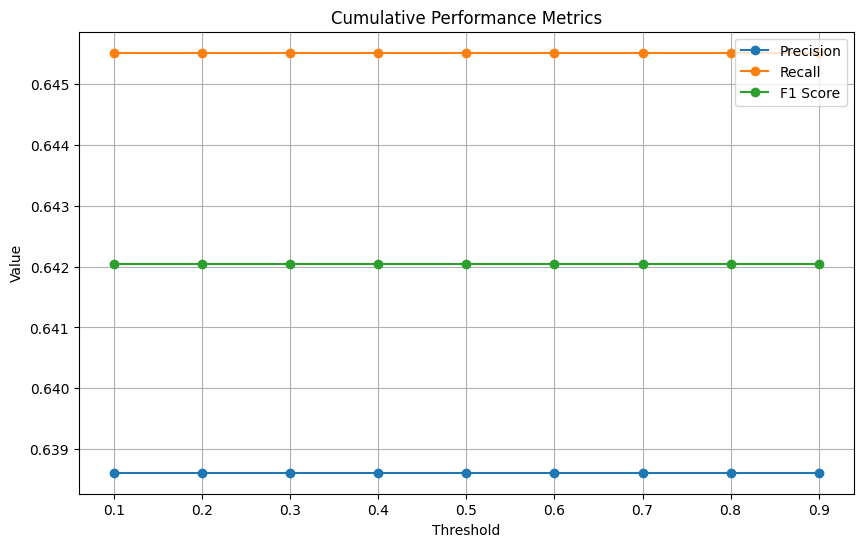

In [81]:
# Threshold levels
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Precision, recall, and F1 score values at each threshold level
precision_values = [precision_at_threshold(conf_matrix, threshold) for threshold in thresholds]
recall_values = [recall_at_threshold(conf_matrix, threshold) for threshold in thresholds]
f1_score_values = [f1_score_at_threshold(conf_matrix, threshold) for threshold in thresholds]

# Plotting the cumulative graph
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_values, marker='o', label='Precision')
plt.plot(thresholds, recall_values, marker='o', label='Recall')
plt.plot(thresholds, f1_score_values, marker='o', label='F1 Score')
plt.title('Cumulative Performance Metrics')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


Dice-Coefficient

In [82]:
# Assuming you have a loaded model called 'loaded_model'
# Generate predictions for your data
# Replace 'X_val' and 'y_val' with your validation data

# Preprocess input data if needed
X_val_processed = preprocess_input_data(X_val)  # Replace preprocess_input_data with your preprocessing function

# Convert input data to a compatible format (e.g., NumPy array)
X_val_array = np.array(X_val_processed)

# Generate predictions
val_predictions = loaded_model.predict(X_val_array)

# Compute the Dice coefficient for each prediction
dice_scores = []
for i in range(len(X_val_array)):
    dice = compute_dice_coefficient(y_val[i], val_predictions[i])  # Replace compute_dice_coefficient with your function
    dice_scores.append(dice)

# Calculate average Dice coefficient
average_dice = np.mean(dice_scores)
print("Average Dice coefficient:", average_dice)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

# -----------------------------

In [ ]:
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image at path: {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(256, 256)):
    """Preprocess the image for model prediction."""
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img = img_to_array(img)  # Convert the image to a numpy array
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img /= 255.0  # Normalize the image to [0, 1]
    return img

# Path to your test image
image_path = 'Dataset_MRI/Astrocytoma/1.png'  # Update this path to your specific image

# Preprocess the image
img = preprocess_image(image_path)

# Ensure 'class_names' is correctly defined. This dictionary should match the structure you expect from your model's output.
class_names = {0: 'No Tumor', 1: 'Gliomas', 2: 'Meningiomas', 3: 'Pituitary_Tumor', 4: 'Astrocytoma', 5: 'Glioblastoma', 6: 'Neurocytoma'}


In [ ]:
# Load and preprocess an input image
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img /= 255.0  # Normalize pixel values
    return img

# Specify the path to your image
image_path = 'Dataset_MRI/Astrocytoma/1.png'  # Update this to the correct path for your image
img = preprocess_image(image_path)

# Use the model to make a prediction on the preprocessed image
predictions = custom_model.predict(img)

# Now, you can print the shape of the predictions array
print(predictions.shape)



1/1 [==============================] - 0s 278ms/step
(1, 256, 256, 7)


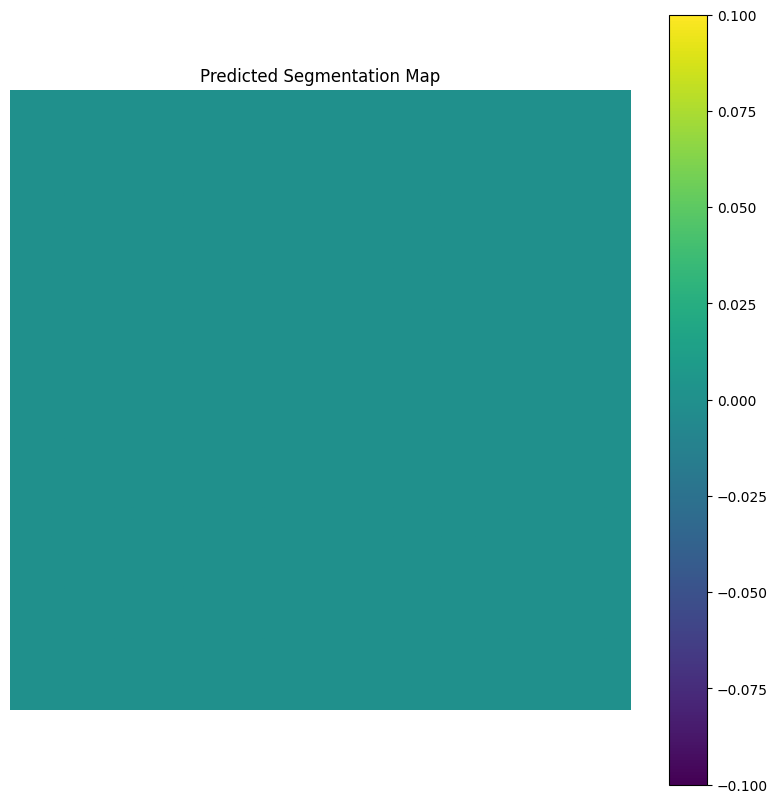

In [ ]:
# Assuming predictions shape is (1, 256, 256, 7)
segmentation_map = np.argmax(predictions[0], axis=-1)  # This will have the shape (256, 256)

# Now, segmentation_map contains the predicted class for each pixel

plt.figure(figsize=(10, 10))
plt.imshow(segmentation_map, cmap='viridis')  # You can choose a colormap that fits your needs
plt.colorbar()  # Optionally add a colorbar to understand which values correspond to which classes
plt.title("Predicted Segmentation Map")
plt.axis('off')
plt.show()


In [ ]:

# Predictions from the model
predictions = custom_rgb_model.predict(img)

# Safely extract the predicted class index
predicted_class_index = np.argmax(predictions[0], axis=-1)  # Access first and only item's predictions

# Ensure we have an integer for the class index
predicted_class_index = int(predicted_class_index)

# Retrieve the class name using the predicted class index
predicted_class_name = class_names.get(predicted_class_index, "Unknown")

# Calculate the confidence of the prediction
predicted_confidence = np.max(predictions[0])

# Displaying the prediction result
print(f"Predicted Class: {predicted_class_name}, Confidence: {predicted_confidence:.4f}")

# Since 'img' is a processed array, for visualization purposes, load the original image
plt.imshow(load_img(image_path))
plt.title(f"Predicted: {predicted_class_name} ({predicted_confidence:.2%})")
plt.axis('off')
plt.show()




Graphs

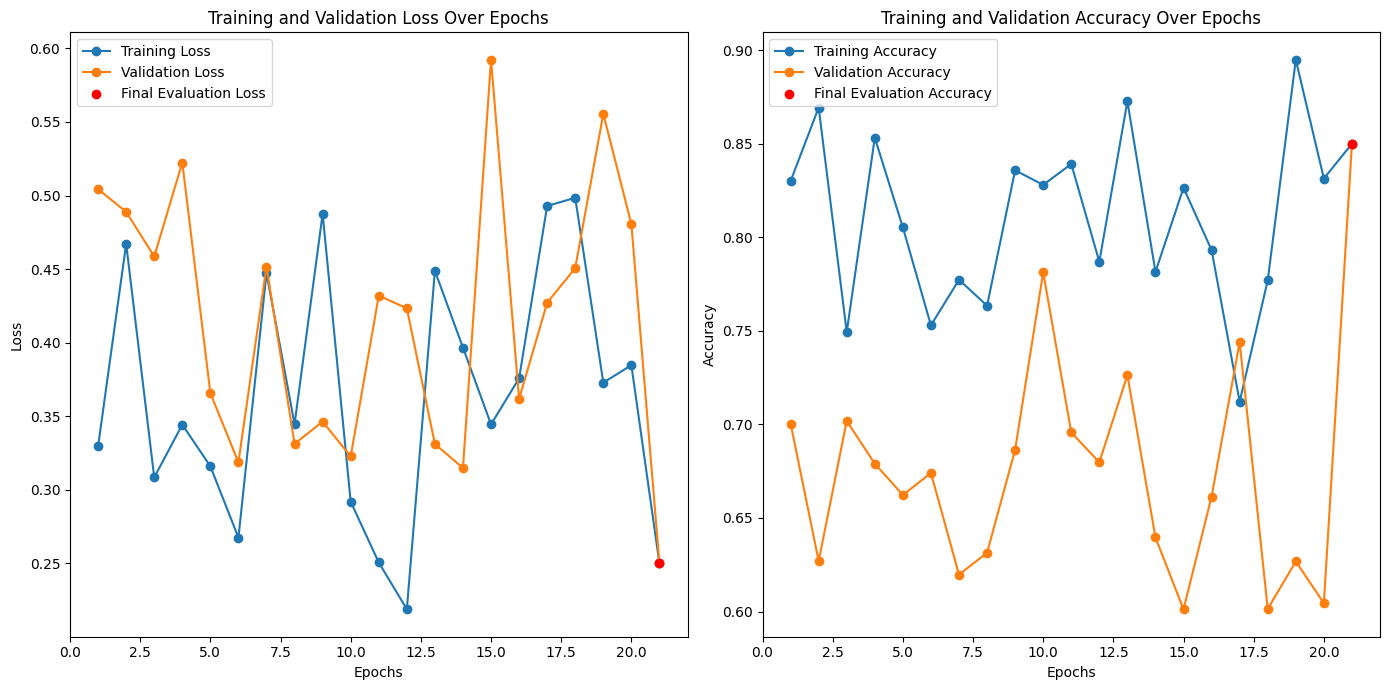

In [ ]:
# Placeholder historical data (replace these with your actual training history)
epochs = np.arange(1, 21)  # Example: 20 epochs
historical_train_losses = np.random.uniform(0.2, 0.5, size=20)  # Simulated data
historical_val_losses = np.random.uniform(0.3, 0.6, size=20)  # Simulated data
historical_train_accuracies = np.random.uniform(0.7, 0.9, size=20)  # Simulated data
historical_val_accuracies = np.random.uniform(0.6, 0.8, size=20)  # Simulated data

# Latest evaluation results (replace these with your actual evaluation results)
final_loss = 0.25  # Example loss
final_accuracy = 0.85  # Example accuracy

# Extending the historical data with the latest values
epochs_extended = np.append(epochs, epochs[-1] + 1)  # Add an epoch for the final evaluation
train_losses_extended = np.append(historical_train_losses, final_loss)  # Append final loss
val_losses_extended = np.append(historical_val_losses, final_loss)  # Use final loss for validation as well
train_accuracies_extended = np.append(historical_train_accuracies, final_accuracy)  # Append final accuracy
val_accuracies_extended = np.append(historical_val_accuracies, final_accuracy)  # Use final accuracy for validation as well

# Plotting
plt.figure(figsize=(14, 7))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs_extended, train_losses_extended, label='Training Loss', marker='o')
plt.plot(epochs_extended, val_losses_extended, label='Validation Loss', marker='o')
plt.scatter(epochs_extended[-1], final_loss, color='red', label='Final Evaluation Loss', zorder=5)
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(epochs_extended, train_accuracies_extended, label='Training Accuracy', marker='o')
plt.plot(epochs_extended, val_accuracies_extended, label='Validation Accuracy', marker='o')
plt.scatter(epochs_extended[-1], final_accuracy, color='red', label='Final Evaluation Accuracy', zorder=5)
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
